In [ ]:
#!pip install pandas-datareader

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
import xgboost as xgb
from tqdm import tqdm_notebook, tqdm
from collections import deque
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
import tensorflow as tf

In [ ]:
class DQN_trader():
  
  def __init__(self, state_size, action_num=3, model_name="DQN_trader"): # state_size指要看過去幾天的價格（window_size)
    
    self.state_size = state_size
    self.action_num = action_num # number = 3 (stay, buy, sell)
    self.memory = deque(maxlen=2000) # 記憶最大2000組
    self.inventory = [] # 買入庫存
    self.model_name = model_name
    
    self.gamma = 0.95
    self.epsilon = 1.0 # 隨機或預測threshold
    self.epsilon_final = 0.01 # 訓練停止點
    self.epsilon_decay = 0.995 # 每次epsilon遞減比率
    
    self.model = self.model_dnn()
    
  def model_dnn(self):
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(units=16, activation='relu', input_dim=self.state_size))
    
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    
    model.add(tf.keras.layers.Dense(units=self.action_num, activation='linear'))
    # 最後輸出3個linear值,然後做argmax
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3))
    
    return model
  
  def trade(self, state):
    # random or use model predict
    
    if random.random() <= self.epsilon: # epsilon在每次dnn訓練後會減少千分之5讓以隨機決策交易的機會降低
      return random.randrange(self.action_num)
    
    actions = self.model.predict(state) #predict出三組數字然後argmax產出0,1,2三個數字 #0Stay, 1Buy, 2Sell
    return np.argmax(actions[0]) 
  
  
  def batch_train(self, batch_size): 
    
    batch = []
    # get pervious action
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i]) # 取出最新32筆memory, 每個memory包含5個items
      
    for state, action, reward, next_state, done in batch:
      reward = reward
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])#引導模型往這次＋預期下次最大reward方向擬合
        
      target = self.model.predict(state)
      target[0][action] = reward
      
      self.model.fit(state, target, epochs=1, verbose=0) #以過去32筆memory訓練模型來做預測
      
    if self.epsilon > self.epsilon_final: # final值為0.01
      self.epsilon *= self.epsilon_decay # epsilon初始值1, 每次遞減千分之五

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
def dataset_loader(stock_name):
  
  #Complete the dataset loader function
  dataset = data_reader.DataReader(stock_name, data_source="yahoo") 
  
  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[-1]).split()[0]
  print(f'dataset loaded with start date {start_date}, end date {end_date}')
  close = dataset['Close'] #收盤價

  return close


def state_creator(data, timestep, window_size): 
#呼叫這個function時會windows+1, 所以返回一個array內有10個0~1之間的float
#因為漲跌幅被壓縮在0~1之間(sigmoid), 此模型會對漲跌幅大小較不敏感
  
  starting_id = timestep - window_size + 1 # timestep指data中的index(依時間排列)
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])
    
  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i])) # 11-1 = 10個
    
  return np.array([state])

In [ ]:
stock_name = "TSM"
data = dataset_loader(stock_name)
#df = data_reader.DataReader(stock_name, data_source="yahoo")

dataset loaded with start date 2015-10-19, end date 2020-10-14


In [ ]:
data.head()

Date
2015-10-19    22.230000
2015-10-20    22.309999
2015-10-21    22.219999
2015-10-22    22.510000
2015-10-23    22.469999
Name: Close, dtype: float64

In [ ]:
len(data)

1257

In [ ]:
window_size = 10 # 依照前10天資料做預測
episodes = 1 # 因時間不足先跑1次

batch_size = 32 # 每次DNN模型訓練使用最新32筆memory
data_samples = len(data) - 1 # 可訓練資料數量（需要nextday-today)

In [ ]:
trader = DQN_trader(window_size) # window_size用來設定DNN的輸入dimension

In [ ]:
trader.model.summary() # 輸出3個linear數字（訓練時3個數字的y值為環境reward)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 11,539
Trainable params: 11,539
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for episode in range(1, episodes + 1):
  
  print("Episode: {}/{}".format(episode, episodes))
  
  #產出第一個state
  state = state_creator(data, 0, window_size + 1)
  
  total_profit = 0
  trader.inventory = []
  
  for t in tqdm(range(data_samples)): # 走完所有資料1257筆
    
    action = trader.trade(state) # 產出第一個action(可能是隨機, 也可能是模型預測)
    
    next_state = state_creator(data, t+1, window_size + 1) # 產出第二個state
    
    # 回饋初始值
    reward = 0
    
    if action == 1: #Buying
      trader.inventory.append(data[t]) # 在此記入買時價格
      print("DQN Trader bought: ", stocks_price_format(data[t]))
      
    elif action == 2 and len(trader.inventory) > 0: #Selling
      buy_price = trader.inventory.pop(0)
      
      reward = max(data[t] - buy_price, 0) # reward指環境回饋, 最小值為0 
      total_profit += data[t] - buy_price # 這裡才反應實際賺賠金額
      print("DQN Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )
      
    if t == data_samples - 1: # 跑到最後一筆資料了(因為需要t+1-t)
      done = True
    else:
      done = False
      
    trader.memory.append((state, action, reward, next_state, done))
    
    state = next_state # 為下個iteration做準備
    
    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    
    if len(trader.memory) > batch_size: # 用今天跟前面31天的memory訓練DNN
      trader.batch_train(batch_size)
      
  if episode % 10 == 0: #每10次episode存下DNN模型
    trader.model.save("/content/gdrive/My Drive/ai_trader_{}.h5".format(episode))
    


  0%|          | 0/1256 [00:00<?, ?it/s]

Episode: 1/1
DQN Trader bought:  $ 22.230000



  0%|          | 1/1256 [00:02<57:24,  2.74s/it]

DQN Trader bought:  $ 22.309999



  0%|          | 2/1256 [00:05<56:52,  2.72s/it]

DQN Trader bought:  $ 22.219999



  0%|          | 3/1256 [00:08<56:47,  2.72s/it]

DQN Trader bought:  $ 22.510000



  0%|          | 4/1256 [00:10<56:15,  2.70s/it]

DQN Trader bought:  $ 22.469999



  0%|          | 5/1256 [00:13<56:02,  2.69s/it]

DQN Trader bought:  $ 22.160000



  0%|          | 6/1256 [00:16<56:41,  2.72s/it]

DQN Trader bought:  $ 22.200001



  1%|          | 7/1256 [00:18<56:10,  2.70s/it]

DQN Trader bought:  $ 22.080000



  1%|          | 8/1256 [00:21<55:59,  2.69s/it]

DQN Trader bought:  $ 21.820000



  1%|          | 9/1256 [00:24<55:44,  2.68s/it]

DQN Trader bought:  $ 21.959999



  1%|          | 10/1256 [00:26<55:23,  2.67s/it]

DQN Trader bought:  $ 22.100000



  1%|          | 11/1256 [00:29<55:15,  2.66s/it]

DQN Trader bought:  $ 22.770000



  1%|          | 12/1256 [00:32<55:46,  2.69s/it]

DQN Trader bought:  $ 23.549999



  1%|          | 13/1256 [00:34<55:45,  2.69s/it]

DQN Trader bought:  $ 22.980000



  1%|          | 14/1256 [00:37<55:30,  2.68s/it]

DQN Trader bought:  $ 22.820000



  1%|          | 15/1256 [00:40<55:23,  2.68s/it]

DQN Trader bought:  $ 22.959999



  1%|▏         | 16/1256 [00:42<55:16,  2.67s/it]

DQN Trader bought:  $ 22.510000



  1%|▏         | 17/1256 [00:45<56:12,  2.72s/it]

DQN Trader bought:  $ 22.580000



  1%|▏         | 18/1256 [00:48<56:10,  2.72s/it]

DQN Trader bought:  $ 22.240000



  2%|▏         | 19/1256 [00:51<56:25,  2.74s/it]

DQN Trader bought:  $ 21.889999



  2%|▏         | 20/1256 [00:53<56:11,  2.73s/it]

DQN Trader bought:  $ 22.350000



  2%|▏         | 21/1256 [00:56<55:30,  2.70s/it]

DQN Trader bought:  $ 22.520000



  2%|▏         | 22/1256 [00:59<55:20,  2.69s/it]

DQN Trader bought:  $ 22.520000



  2%|▏         | 23/1256 [01:02<56:13,  2.74s/it]

DQN Trader bought:  $ 22.670000



  2%|▏         | 24/1256 [01:04<56:04,  2.73s/it]

DQN Trader bought:  $ 22.830000



  2%|▏         | 25/1256 [01:07<56:01,  2.73s/it]

DQN Trader bought:  $ 22.570000



  2%|▏         | 26/1256 [01:10<55:43,  2.72s/it]

DQN Trader bought:  $ 22.500000



  2%|▏         | 27/1256 [01:12<55:19,  2.70s/it]

DQN Trader bought:  $ 22.559999



  2%|▏         | 28/1256 [01:15<55:07,  2.69s/it]

DQN Trader bought:  $ 22.450001



  2%|▏         | 29/1256 [01:18<56:14,  2.75s/it]

DQN Trader bought:  $ 22.760000



  2%|▏         | 30/1256 [01:21<55:41,  2.73s/it]

DQN Trader bought:  $ 23.280001



  2%|▏         | 31/1256 [01:23<55:21,  2.71s/it]

DQN Trader bought:  $ 23.190001



  3%|▎         | 32/1256 [01:26<55:04,  2.70s/it]

DQN Trader bought:  $ 22.930000



  3%|▎         | 33/1256 [01:29<54:34,  2.68s/it]

DQN Trader bought:  $ 23.309999



  3%|▎         | 34/1256 [01:31<54:21,  2.67s/it]

DQN Trader bought:  $ 23.240000



  3%|▎         | 35/1256 [01:34<55:03,  2.71s/it]

DQN Trader bought:  $ 23.080000



  3%|▎         | 36/1256 [01:37<55:13,  2.72s/it]

DQN Trader bought:  $ 22.730000



  3%|▎         | 37/1256 [01:39<55:00,  2.71s/it]

DQN Trader bought:  $ 22.650000



  3%|▎         | 38/1256 [01:42<54:53,  2.70s/it]

DQN Trader bought:  $ 22.180000



  3%|▎         | 39/1256 [01:45<54:48,  2.70s/it]

DQN Trader sold:  $ 22.219999  Profit: - $ 0.010000



  3%|▎         | 40/1256 [01:48<54:25,  2.69s/it]

DQN Trader bought:  $ 22.820000



  3%|▎         | 41/1256 [01:50<55:27,  2.74s/it]

DQN Trader bought:  $ 23.160000



  3%|▎         | 42/1256 [01:53<55:32,  2.75s/it]

DQN Trader bought:  $ 22.959999



  3%|▎         | 43/1256 [01:56<55:15,  2.73s/it]

DQN Trader bought:  $ 22.930000



  4%|▎         | 44/1256 [01:59<54:48,  2.71s/it]

DQN Trader bought:  $ 22.950001



  4%|▎         | 45/1256 [02:01<54:45,  2.71s/it]

DQN Trader bought:  $ 23.059999



  4%|▎         | 46/1256 [02:04<55:56,  2.77s/it]

DQN Trader bought:  $ 23.080000



  4%|▎         | 47/1256 [02:07<56:02,  2.78s/it]

DQN Trader bought:  $ 23.150000



  4%|▍         | 48/1256 [02:10<55:42,  2.77s/it]

DQN Trader bought:  $ 23.010000



  4%|▍         | 49/1256 [02:12<55:42,  2.77s/it]

DQN Trader bought:  $ 23.080000



  4%|▍         | 50/1256 [02:15<55:10,  2.74s/it]

DQN Trader bought:  $ 22.879999



  4%|▍         | 51/1256 [02:18<54:38,  2.72s/it]

DQN Trader bought:  $ 22.750000



  4%|▍         | 52/1256 [02:21<55:21,  2.76s/it]

DQN Trader bought:  $ 22.090000



  4%|▍         | 53/1256 [02:23<55:10,  2.75s/it]

DQN Trader sold:  $ 21.950001  Profit: - $ 0.359999



  4%|▍         | 54/1256 [02:26<54:58,  2.74s/it]

DQN Trader sold:  $ 21.340000  Profit: - $ 0.879999



  4%|▍         | 55/1256 [02:29<54:53,  2.74s/it]

DQN Trader sold:  $ 21.100000  Profit: - $ 1.410000



  4%|▍         | 56/1256 [02:32<54:34,  2.73s/it]

DQN Trader sold:  $ 20.809999  Profit: - $ 1.660000



  5%|▍         | 57/1256 [02:34<54:08,  2.71s/it]

DQN Trader sold:  $ 20.930000  Profit: - $ 1.230000



  5%|▍         | 58/1256 [02:37<54:49,  2.75s/it]

DQN Trader bought:  $ 20.750000



  5%|▍         | 59/1256 [02:40<54:30,  2.73s/it]

DQN Trader sold:  $ 20.480000  Profit: - $ 1.720001



  5%|▍         | 60/1256 [02:42<54:04,  2.71s/it]

DQN Trader sold:  $ 21.820000  Profit: - $ 0.260000



  5%|▍         | 61/1256 [02:45<53:44,  2.70s/it]

DQN Trader sold:  $ 21.100000  Profit: - $ 0.719999



  5%|▍         | 62/1256 [02:48<53:30,  2.69s/it]

DQN Trader bought:  $ 21.660000



  5%|▌         | 63/1256 [02:51<53:59,  2.72s/it]

DQN Trader sold:  $ 21.090000  Profit: - $ 0.869999



  5%|▌         | 64/1256 [02:53<53:55,  2.71s/it]

DQN Trader bought:  $ 21.330000



  5%|▌         | 65/1256 [02:56<53:32,  2.70s/it]

DQN Trader bought:  $ 21.930000



  5%|▌         | 66/1256 [02:59<53:08,  2.68s/it]

DQN Trader bought:  $ 21.790001



  5%|▌         | 67/1256 [03:01<52:54,  2.67s/it]

DQN Trader bought:  $ 21.590000



  5%|▌         | 68/1256 [03:04<52:33,  2.65s/it]

DQN Trader bought:  $ 21.680000



  5%|▌         | 69/1256 [03:07<53:28,  2.70s/it]

DQN Trader bought:  $ 21.629999



  6%|▌         | 70/1256 [03:09<53:08,  2.69s/it]

DQN Trader bought:  $ 22.350000



  6%|▌         | 71/1256 [03:12<52:49,  2.67s/it]

DQN Trader bought:  $ 22.459999



  6%|▌         | 72/1256 [03:15<52:35,  2.67s/it]

DQN Trader bought:  $ 22.559999



  6%|▌         | 73/1256 [03:17<52:26,  2.66s/it]

DQN Trader bought:  $ 22.920000



  6%|▌         | 74/1256 [03:20<52:21,  2.66s/it]

DQN Trader bought:  $ 23.230000



  6%|▌         | 75/1256 [03:23<53:22,  2.71s/it]

DQN Trader bought:  $ 22.750000



  6%|▌         | 76/1256 [03:25<53:13,  2.71s/it]

DQN Trader bought:  $ 22.799999



  6%|▌         | 77/1256 [03:28<52:57,  2.69s/it]

DQN Trader bought:  $ 22.559999



  6%|▌         | 78/1256 [03:31<52:45,  2.69s/it]

DQN Trader bought:  $ 22.299999



  6%|▋         | 79/1256 [03:33<52:40,  2.68s/it]

DQN Trader bought:  $ 22.000000



  6%|▋         | 80/1256 [03:36<52:42,  2.69s/it]

DQN Trader bought:  $ 22.240000



  6%|▋         | 81/1256 [03:39<53:22,  2.73s/it]

DQN Trader bought:  $ 23.340000



  7%|▋         | 82/1256 [03:42<53:19,  2.73s/it]

DQN Trader bought:  $ 23.639999



  7%|▋         | 83/1256 [03:44<53:18,  2.73s/it]

DQN Trader bought:  $ 23.799999



  7%|▋         | 84/1256 [03:47<53:09,  2.72s/it]

DQN Trader bought:  $ 23.780001



  7%|▋         | 85/1256 [03:50<52:58,  2.71s/it]

DQN Trader bought:  $ 23.959999



  7%|▋         | 86/1256 [03:52<52:47,  2.71s/it]

DQN Trader bought:  $ 23.400000



  7%|▋         | 87/1256 [03:55<53:38,  2.75s/it]

DQN Trader bought:  $ 23.420000



  7%|▋         | 88/1256 [03:58<53:10,  2.73s/it]

DQN Trader bought:  $ 23.690001



  7%|▋         | 89/1256 [04:01<52:50,  2.72s/it]

DQN Trader bought:  $ 23.770000



  7%|▋         | 90/1256 [04:03<52:34,  2.71s/it]

DQN Trader bought:  $ 23.549999



  7%|▋         | 91/1256 [04:06<52:27,  2.70s/it]

DQN Trader bought:  $ 24.580000



  7%|▋         | 92/1256 [04:09<52:55,  2.73s/it]

DQN Trader bought:  $ 24.620001



  7%|▋         | 93/1256 [04:12<52:30,  2.71s/it]

DQN Trader bought:  $ 24.559999



  7%|▋         | 94/1256 [04:14<52:10,  2.69s/it]

DQN Trader bought:  $ 24.650000



  8%|▊         | 95/1256 [04:17<51:59,  2.69s/it]

DQN Trader bought:  $ 24.700001



  8%|▊         | 96/1256 [04:20<51:48,  2.68s/it]

DQN Trader bought:  $ 24.650000



  8%|▊         | 97/1256 [04:22<51:39,  2.67s/it]

DQN Trader bought:  $ 24.740000



  8%|▊         | 98/1256 [04:25<52:22,  2.71s/it]

DQN Trader bought:  $ 24.740000



  8%|▊         | 99/1256 [04:28<52:14,  2.71s/it]

DQN Trader bought:  $ 25.350000



  8%|▊         | 100/1256 [04:30<51:59,  2.70s/it]

DQN Trader bought:  $ 25.219999



  8%|▊         | 101/1256 [04:33<51:44,  2.69s/it]

DQN Trader bought:  $ 24.879999



  8%|▊         | 102/1256 [04:36<51:29,  2.68s/it]

DQN Trader bought:  $ 25.780001



  8%|▊         | 103/1256 [04:38<51:23,  2.67s/it]

DQN Trader bought:  $ 25.770000



  8%|▊         | 104/1256 [04:41<52:03,  2.71s/it]

DQN Trader bought:  $ 26.040001



  8%|▊         | 105/1256 [04:44<51:38,  2.69s/it]

DQN Trader bought:  $ 25.930000



  8%|▊         | 106/1256 [04:46<51:24,  2.68s/it]

DQN Trader bought:  $ 25.809999



  9%|▊         | 107/1256 [04:49<51:07,  2.67s/it]

DQN Trader bought:  $ 25.680000



  9%|▊         | 108/1256 [04:52<51:03,  2.67s/it]

DQN Trader bought:  $ 25.730000



  9%|▊         | 109/1256 [04:54<51:02,  2.67s/it]

DQN Trader bought:  $ 25.629999



  9%|▉         | 110/1256 [04:57<51:48,  2.71s/it]

DQN Trader bought:  $ 25.969999



  9%|▉         | 111/1256 [05:00<51:34,  2.70s/it]

DQN Trader bought:  $ 26.459999



  9%|▉         | 112/1256 [05:03<51:26,  2.70s/it]

DQN Trader bought:  $ 26.200001



  9%|▉         | 113/1256 [05:05<51:17,  2.69s/it]

DQN Trader bought:  $ 26.120001



  9%|▉         | 114/1256 [05:08<51:16,  2.69s/it]

DQN Trader bought:  $ 25.850000



  9%|▉         | 115/1256 [05:11<51:29,  2.71s/it]

DQN Trader bought:  $ 25.510000



  9%|▉         | 116/1256 [05:14<52:03,  2.74s/it]

DQN Trader sold:  $ 25.620001  Profit: $ 3.520000



  9%|▉         | 117/1256 [05:16<51:29,  2.71s/it]

DQN Trader sold:  $ 25.370001  Profit: $ 2.600000



  9%|▉         | 118/1256 [05:19<51:14,  2.70s/it]

DQN Trader sold:  $ 25.280001  Profit: $ 1.730001



  9%|▉         | 119/1256 [05:22<50:54,  2.69s/it]

DQN Trader sold:  $ 25.510000  Profit: $ 2.530001



 10%|▉         | 120/1256 [05:24<50:38,  2.67s/it]

DQN Trader sold:  $ 25.570000  Profit: $ 2.750000



 10%|▉         | 121/1256 [05:27<50:19,  2.66s/it]

DQN Trader sold:  $ 26.170000  Profit: $ 3.210001



 10%|▉         | 122/1256 [05:30<51:07,  2.71s/it]

DQN Trader sold:  $ 25.299999  Profit: $ 2.789999



 10%|▉         | 123/1256 [05:32<50:46,  2.69s/it]

DQN Trader sold:  $ 25.459999  Profit: $ 2.879999



 10%|▉         | 124/1256 [05:35<50:34,  2.68s/it]

DQN Trader sold:  $ 25.500000  Profit: $ 3.260000



 10%|▉         | 125/1256 [05:38<50:18,  2.67s/it]

DQN Trader sold:  $ 25.160000  Profit: $ 3.270000



 10%|█         | 126/1256 [05:40<50:09,  2.66s/it]

DQN Trader sold:  $ 25.120001  Profit: $ 2.770000



 10%|█         | 127/1256 [05:43<50:53,  2.70s/it]

DQN Trader sold:  $ 25.160000  Profit: $ 2.639999



 10%|█         | 128/1256 [05:46<50:39,  2.69s/it]

DQN Trader sold:  $ 25.070000  Profit: $ 2.549999



 10%|█         | 129/1256 [05:48<50:29,  2.69s/it]

DQN Trader sold:  $ 25.010000  Profit: $ 2.340000



 10%|█         | 130/1256 [05:51<50:18,  2.68s/it]

DQN Trader sold:  $ 25.010000  Profit: $ 2.180000



 10%|█         | 131/1256 [05:54<50:34,  2.70s/it]

DQN Trader sold:  $ 25.250000  Profit: $ 2.680000



 11%|█         | 132/1256 [05:56<50:41,  2.71s/it]

DQN Trader sold:  $ 24.160000  Profit: $ 1.660000



 11%|█         | 133/1256 [05:59<51:28,  2.75s/it]

DQN Trader sold:  $ 23.590000  Profit: $ 1.030001



 11%|█         | 134/1256 [06:02<51:09,  2.74s/it]

DQN Trader sold:  $ 23.690001  Profit: $ 1.240000



 11%|█         | 135/1256 [06:05<50:55,  2.73s/it]

DQN Trader sold:  $ 23.320000  Profit: $ 0.559999



 11%|█         | 136/1256 [06:07<50:53,  2.73s/it]

DQN Trader sold:  $ 23.420000  Profit: $ 0.139999



 11%|█         | 137/1256 [06:10<50:33,  2.71s/it]

DQN Trader bought:  $ 23.500000



 11%|█         | 138/1256 [06:13<50:23,  2.70s/it]

DQN Trader sold:  $ 23.410000  Profit: $ 0.219999



 11%|█         | 139/1256 [06:16<50:58,  2.74s/it]

DQN Trader bought:  $ 23.370001



 11%|█         | 140/1256 [06:18<50:33,  2.72s/it]

DQN Trader sold:  $ 23.389999  Profit: $ 0.459999



 11%|█         | 141/1256 [06:21<50:14,  2.70s/it]

DQN Trader sold:  $ 23.219999  Profit: - $ 0.090000



 11%|█▏        | 142/1256 [06:24<50:18,  2.71s/it]

DQN Trader sold:  $ 22.990000  Profit: - $ 0.250000



 11%|█▏        | 143/1256 [06:26<50:20,  2.71s/it]

DQN Trader sold:  $ 22.820000  Profit: - $ 0.260000



 11%|█▏        | 144/1256 [06:29<50:13,  2.71s/it]

DQN Trader sold:  $ 23.110001  Profit: $ 0.380001



 12%|█▏        | 145/1256 [06:32<51:04,  2.76s/it]

DQN Trader sold:  $ 22.950001  Profit: $ 0.300001



 12%|█▏        | 146/1256 [06:35<50:54,  2.75s/it]

DQN Trader sold:  $ 23.520000  Profit: $ 1.340000



 12%|█▏        | 147/1256 [06:37<50:31,  2.73s/it]

DQN Trader sold:  $ 23.250000  Profit: $ 0.430000



 12%|█▏        | 148/1256 [06:40<50:13,  2.72s/it]

DQN Trader sold:  $ 23.910000  Profit: $ 0.750000



 12%|█▏        | 149/1256 [06:43<49:47,  2.70s/it]

DQN Trader sold:  $ 24.270000  Profit: $ 1.310001



 12%|█▏        | 150/1256 [06:45<49:32,  2.69s/it]

DQN Trader sold:  $ 24.469999  Profit: $ 1.539999



 12%|█▏        | 151/1256 [06:48<50:07,  2.72s/it]

DQN Trader sold:  $ 24.620001  Profit: $ 1.670000



 12%|█▏        | 152/1256 [06:51<49:49,  2.71s/it]

DQN Trader sold:  $ 24.790001  Profit: $ 1.730001



 12%|█▏        | 153/1256 [06:54<49:24,  2.69s/it]

DQN Trader sold:  $ 24.799999  Profit: $ 1.719999



 12%|█▏        | 154/1256 [06:56<49:09,  2.68s/it]

DQN Trader sold:  $ 24.719999  Profit: $ 1.570000



 12%|█▏        | 155/1256 [06:59<48:59,  2.67s/it]

DQN Trader sold:  $ 25.250000  Profit: $ 2.240000



 12%|█▏        | 156/1256 [07:02<49:43,  2.71s/it]

DQN Trader sold:  $ 25.180000  Profit: $ 2.100000



 12%|█▎        | 157/1256 [07:04<49:35,  2.71s/it]

DQN Trader sold:  $ 25.530001  Profit: $ 2.650002



 13%|█▎        | 158/1256 [07:07<49:32,  2.71s/it]

DQN Trader sold:  $ 25.469999  Profit: $ 2.719999



 13%|█▎        | 159/1256 [07:10<49:11,  2.69s/it]

DQN Trader sold:  $ 26.059999  Profit: $ 3.969999



 13%|█▎        | 160/1256 [07:12<49:14,  2.70s/it]

DQN Trader sold:  $ 26.330000  Profit: $ 5.580000



 13%|█▎        | 161/1256 [07:15<49:19,  2.70s/it]

DQN Trader sold:  $ 26.230000  Profit: $ 4.570000



 13%|█▎        | 162/1256 [07:18<50:17,  2.76s/it]

DQN Trader sold:  $ 25.860001  Profit: $ 4.530001



 13%|█▎        | 163/1256 [07:21<50:14,  2.76s/it]

DQN Trader sold:  $ 25.629999  Profit: $ 3.699999



 13%|█▎        | 164/1256 [07:24<49:59,  2.75s/it]

DQN Trader sold:  $ 25.570000  Profit: $ 3.779999



 13%|█▎        | 165/1256 [07:26<49:15,  2.71s/it]

DQN Trader sold:  $ 25.840000  Profit: $ 4.250000



 13%|█▎        | 166/1256 [07:29<48:52,  2.69s/it]

DQN Trader sold:  $ 25.860001  Profit: $ 4.180000



 13%|█▎        | 167/1256 [07:31<48:36,  2.68s/it]

DQN Trader sold:  $ 25.850000  Profit: $ 4.220001



 13%|█▎        | 168/1256 [07:34<49:21,  2.72s/it]

DQN Trader sold:  $ 26.370001  Profit: $ 4.020000



 13%|█▎        | 169/1256 [07:37<49:05,  2.71s/it]

DQN Trader sold:  $ 26.590000  Profit: $ 4.130001



 14%|█▎        | 170/1256 [07:40<48:50,  2.70s/it]

DQN Trader sold:  $ 26.540001  Profit: $ 3.980001



 14%|█▎        | 171/1256 [07:42<48:34,  2.69s/it]

DQN Trader sold:  $ 26.809999  Profit: $ 3.889999



 14%|█▎        | 172/1256 [07:45<48:33,  2.69s/it]

DQN Trader sold:  $ 25.680000  Profit: $ 2.450001



 14%|█▍        | 173/1256 [07:48<48:30,  2.69s/it]

DQN Trader sold:  $ 24.900000  Profit: $ 2.150000



 14%|█▍        | 174/1256 [07:50<49:09,  2.73s/it]

DQN Trader sold:  $ 25.260000  Profit: $ 2.460001



 14%|█▍        | 175/1256 [07:53<48:57,  2.72s/it]

DQN Trader sold:  $ 25.799999  Profit: $ 3.240000



 14%|█▍        | 176/1256 [07:56<48:30,  2.69s/it]

DQN Trader sold:  $ 26.230000  Profit: $ 3.930000



 14%|█▍        | 177/1256 [07:58<48:05,  2.67s/it]

DQN Trader sold:  $ 26.530001  Profit: $ 4.530001



 14%|█▍        | 178/1256 [08:01<47:48,  2.66s/it]

DQN Trader sold:  $ 26.260000  Profit: $ 4.020000



 14%|█▍        | 179/1256 [08:04<47:44,  2.66s/it]

DQN Trader sold:  $ 26.150000  Profit: $ 2.809999



 14%|█▍        | 180/1256 [08:07<48:37,  2.71s/it]

DQN Trader sold:  $ 26.309999  Profit: $ 2.670000



 14%|█▍        | 181/1256 [08:09<48:20,  2.70s/it]

DQN Trader sold:  $ 26.730000  Profit: $ 2.930000



 14%|█▍        | 182/1256 [08:12<48:07,  2.69s/it]

DQN Trader sold:  $ 27.200001  Profit: $ 3.420000



 15%|█▍        | 183/1256 [08:15<47:55,  2.68s/it]

DQN Trader sold:  $ 26.969999  Profit: $ 3.010000



 15%|█▍        | 184/1256 [08:17<47:32,  2.66s/it]

DQN Trader sold:  $ 26.889999  Profit: $ 3.490000



 15%|█▍        | 185/1256 [08:20<48:10,  2.70s/it]

DQN Trader sold:  $ 27.110001  Profit: $ 3.690001



 15%|█▍        | 186/1256 [08:23<47:54,  2.69s/it]

DQN Trader sold:  $ 27.010000  Profit: $ 3.320000



 15%|█▍        | 187/1256 [08:25<47:35,  2.67s/it]

DQN Trader sold:  $ 27.639999  Profit: $ 3.869999



 15%|█▍        | 188/1256 [08:28<47:12,  2.65s/it]

DQN Trader sold:  $ 27.270000  Profit: $ 3.720001



 15%|█▌        | 189/1256 [08:30<47:03,  2.65s/it]

DQN Trader sold:  $ 27.549999  Profit: $ 2.969999



 15%|█▌        | 190/1256 [08:33<47:01,  2.65s/it]

DQN Trader sold:  $ 27.480000  Profit: $ 2.859999



 15%|█▌        | 191/1256 [08:36<47:43,  2.69s/it]

DQN Trader sold:  $ 27.740000  Profit: $ 3.180000



 15%|█▌        | 192/1256 [08:39<47:28,  2.68s/it]

DQN Trader sold:  $ 27.860001  Profit: $ 3.210001



 15%|█▌        | 193/1256 [08:41<47:22,  2.67s/it]

DQN Trader sold:  $ 28.330000  Profit: $ 3.629999



 15%|█▌        | 194/1256 [08:44<47:10,  2.67s/it]

DQN Trader sold:  $ 28.100000  Profit: $ 3.450001



 16%|█▌        | 195/1256 [08:47<47:03,  2.66s/it]

DQN Trader sold:  $ 28.139999  Profit: $ 3.400000



 16%|█▌        | 196/1256 [08:49<46:57,  2.66s/it]

DQN Trader sold:  $ 27.780001  Profit: $ 3.040001



 16%|█▌        | 197/1256 [08:52<47:35,  2.70s/it]

DQN Trader sold:  $ 28.620001  Profit: $ 3.270000



 16%|█▌        | 198/1256 [08:55<47:38,  2.70s/it]

DQN Trader sold:  $ 28.160000  Profit: $ 2.940001



 16%|█▌        | 199/1256 [08:57<47:35,  2.70s/it]

DQN Trader sold:  $ 28.160000  Profit: $ 3.280001



 16%|█▌        | 200/1256 [09:00<47:21,  2.69s/it]

DQN Trader sold:  $ 28.400000  Profit: $ 2.619999



 16%|█▌        | 201/1256 [09:03<47:16,  2.69s/it]

DQN Trader sold:  $ 28.790001  Profit: $ 3.020000



 16%|█▌        | 202/1256 [09:05<47:23,  2.70s/it]

DQN Trader sold:  $ 29.090000  Profit: $ 3.049999



 16%|█▌        | 203/1256 [09:08<48:17,  2.75s/it]

DQN Trader sold:  $ 29.400000  Profit: $ 3.469999



 16%|█▌        | 204/1256 [09:11<48:00,  2.74s/it]

DQN Trader sold:  $ 29.219999  Profit: $ 3.410000



 16%|█▋        | 205/1256 [09:14<47:42,  2.72s/it]

DQN Trader sold:  $ 29.139999  Profit: $ 3.459999



 16%|█▋        | 206/1256 [09:16<47:15,  2.70s/it]

DQN Trader sold:  $ 29.240000  Profit: $ 3.510000



 16%|█▋        | 207/1256 [09:19<46:57,  2.69s/it]

DQN Trader sold:  $ 29.389999  Profit: $ 3.760000



 17%|█▋        | 208/1256 [09:22<46:36,  2.67s/it]

DQN Trader sold:  $ 29.080000  Profit: $ 3.110001



 17%|█▋        | 209/1256 [09:24<47:13,  2.71s/it]

DQN Trader sold:  $ 28.980000  Profit: $ 2.520000



 17%|█▋        | 210/1256 [09:27<46:54,  2.69s/it]

DQN Trader sold:  $ 29.160000  Profit: $ 2.959999



 17%|█▋        | 211/1256 [09:30<46:32,  2.67s/it]

DQN Trader sold:  $ 28.639999  Profit: $ 2.519999



 17%|█▋        | 212/1256 [09:32<46:29,  2.67s/it]

DQN Trader sold:  $ 28.400000  Profit: $ 2.549999



 17%|█▋        | 213/1256 [09:35<46:23,  2.67s/it]

DQN Trader sold:  $ 28.500000  Profit: $ 2.990000



 17%|█▋        | 214/1256 [09:38<46:58,  2.71s/it]

DQN Trader sold:  $ 28.389999  Profit: $ 4.889999



 17%|█▋        | 215/1256 [09:40<46:41,  2.69s/it]

DQN Trader sold:  $ 28.600000  Profit: $ 5.230000



 18%|█▊        | 231/1256 [10:23<45:24,  2.66s/it]

DQN Trader bought:  $ 29.930000



 18%|█▊        | 232/1256 [10:26<46:13,  2.71s/it]

DQN Trader bought:  $ 29.900000



 19%|█▊        | 233/1256 [10:29<46:01,  2.70s/it]

DQN Trader sold:  $ 30.500000  Profit: $ 0.570000



 19%|█▊        | 234/1256 [10:31<45:52,  2.69s/it]

DQN Trader sold:  $ 30.660000  Profit: $ 0.760000



 20%|█▉        | 246/1256 [11:03<45:08,  2.68s/it]

DQN Trader bought:  $ 31.280001



 20%|█▉        | 247/1256 [11:06<44:56,  2.67s/it]

DQN Trader bought:  $ 30.730000



 20%|█▉        | 248/1256 [11:09<45:31,  2.71s/it]

DQN Trader bought:  $ 31.350000



 20%|█▉        | 249/1256 [11:12<45:07,  2.69s/it]

DQN Trader bought:  $ 30.530001



 20%|█▉        | 250/1256 [11:14<45:00,  2.68s/it]

DQN Trader bought:  $ 30.660000



 20%|█▉        | 251/1256 [11:17<44:47,  2.67s/it]

DQN Trader sold:  $ 30.570000  Profit: - $ 0.710001



 20%|██        | 252/1256 [11:20<44:46,  2.68s/it]

DQN Trader sold:  $ 30.860001  Profit: $ 0.130001



 20%|██        | 253/1256 [11:22<44:34,  2.67s/it]

DQN Trader bought:  $ 30.980000



 20%|██        | 254/1256 [11:25<45:06,  2.70s/it]

DQN Trader sold:  $ 31.059999  Profit: - $ 0.290001



 20%|██        | 255/1256 [11:28<44:52,  2.69s/it]

DQN Trader bought:  $ 31.080000



 20%|██        | 256/1256 [11:30<44:25,  2.67s/it]

DQN Trader sold:  $ 31.410000  Profit: $ 0.879999



 20%|██        | 257/1256 [11:33<44:13,  2.66s/it]

DQN Trader bought:  $ 31.549999



 21%|██        | 258/1256 [11:36<44:19,  2.66s/it]

DQN Trader bought:  $ 31.209999



 21%|██        | 259/1256 [11:38<44:07,  2.66s/it]

DQN Trader sold:  $ 30.770000  Profit: $ 0.110001



 21%|██        | 260/1256 [11:41<44:41,  2.69s/it]

DQN Trader sold:  $ 30.770000  Profit: - $ 0.209999



 21%|██        | 261/1256 [11:44<44:26,  2.68s/it]

DQN Trader sold:  $ 31.100000  Profit: $ 0.020000



 21%|██        | 262/1256 [11:46<44:17,  2.67s/it]

DQN Trader sold:  $ 30.709999  Profit: - $ 0.840000



 21%|██        | 263/1256 [11:49<44:30,  2.69s/it]

DQN Trader bought:  $ 30.389999



 21%|██        | 264/1256 [11:52<44:23,  2.69s/it]

DQN Trader sold:  $ 30.280001  Profit: - $ 0.929998



 21%|██        | 265/1256 [11:54<44:27,  2.69s/it]

DQN Trader sold:  $ 30.240000  Profit: - $ 0.150000



 21%|██▏       | 268/1256 [12:02<44:15,  2.69s/it]

DQN Trader bought:  $ 30.590000



 21%|██▏       | 269/1256 [12:05<43:52,  2.67s/it]

DQN Trader sold:  $ 29.440001  Profit: - $ 1.150000



 22%|██▏       | 274/1256 [12:18<43:38,  2.67s/it]

DQN Trader bought:  $ 29.469999



 22%|██▏       | 275/1256 [12:21<43:43,  2.67s/it]

DQN Trader bought:  $ 29.469999



 22%|██▏       | 276/1256 [12:24<44:01,  2.70s/it]

DQN Trader sold:  $ 29.650000  Profit: $ 0.180000



 22%|██▏       | 277/1256 [12:27<44:54,  2.75s/it]

DQN Trader bought:  $ 29.910000



 22%|██▏       | 278/1256 [12:30<44:45,  2.75s/it]

DQN Trader bought:  $ 29.889999



 22%|██▏       | 279/1256 [12:32<44:52,  2.76s/it]

DQN Trader bought:  $ 29.660000



 22%|██▏       | 280/1256 [12:35<44:34,  2.74s/it]

DQN Trader bought:  $ 29.660000



 22%|██▏       | 281/1256 [12:38<44:15,  2.72s/it]

DQN Trader bought:  $ 29.549999



 22%|██▏       | 282/1256 [12:40<43:54,  2.70s/it]

DQN Trader bought:  $ 29.690001



 23%|██▎       | 283/1256 [12:43<44:17,  2.73s/it]

DQN Trader bought:  $ 28.549999



 23%|██▎       | 284/1256 [12:46<43:52,  2.71s/it]

DQN Trader bought:  $ 28.860001



 23%|██▎       | 285/1256 [12:48<43:37,  2.70s/it]

DQN Trader bought:  $ 29.020000



 23%|██▎       | 286/1256 [12:51<43:31,  2.69s/it]

DQN Trader bought:  $ 29.510000



 23%|██▎       | 287/1256 [12:54<43:21,  2.68s/it]

DQN Trader bought:  $ 29.930000



 23%|██▎       | 288/1256 [12:57<43:26,  2.69s/it]

DQN Trader bought:  $ 30.040001



 23%|██▎       | 289/1256 [12:59<43:52,  2.72s/it]

DQN Trader bought:  $ 30.120001



 23%|██▎       | 290/1256 [13:02<43:30,  2.70s/it]

DQN Trader bought:  $ 29.900000



 23%|██▎       | 291/1256 [13:05<43:16,  2.69s/it]

DQN Trader bought:  $ 30.360001



 23%|██▎       | 292/1256 [13:07<43:15,  2.69s/it]

DQN Trader bought:  $ 29.870001



 23%|██▎       | 293/1256 [13:10<43:08,  2.69s/it]

DQN Trader bought:  $ 30.160000



 23%|██▎       | 294/1256 [13:13<43:44,  2.73s/it]

DQN Trader bought:  $ 29.480000



 23%|██▎       | 295/1256 [13:15<43:25,  2.71s/it]

DQN Trader bought:  $ 29.270000



 24%|██▎       | 296/1256 [13:18<43:10,  2.70s/it]

DQN Trader bought:  $ 29.309999



 24%|██▎       | 297/1256 [13:21<42:59,  2.69s/it]

DQN Trader bought:  $ 29.139999



 24%|██▎       | 298/1256 [13:23<42:44,  2.68s/it]

DQN Trader bought:  $ 28.740000



 24%|██▍       | 299/1256 [13:26<42:44,  2.68s/it]

DQN Trader bought:  $ 29.049999



 24%|██▍       | 300/1256 [13:29<43:19,  2.72s/it]

DQN Trader bought:  $ 29.100000



 24%|██▍       | 301/1256 [13:32<42:57,  2.70s/it]

DQN Trader bought:  $ 29.120001



 24%|██▍       | 302/1256 [13:34<42:44,  2.69s/it]

DQN Trader bought:  $ 29.129999



 24%|██▍       | 303/1256 [13:37<42:33,  2.68s/it]

DQN Trader sold:  $ 28.750000  Profit: - $ 0.719999



 24%|██▍       | 305/1256 [13:42<42:03,  2.65s/it]

DQN Trader bought:  $ 29.299999



 24%|██▍       | 306/1256 [13:45<42:39,  2.69s/it]

DQN Trader sold:  $ 29.799999  Profit: - $ 0.110001



 24%|██▍       | 307/1256 [13:48<42:33,  2.69s/it]

DQN Trader sold:  $ 29.629999  Profit: - $ 0.260000



 25%|██▍       | 308/1256 [13:50<42:23,  2.68s/it]

DQN Trader sold:  $ 30.040001  Profit: $ 0.380001



 25%|██▍       | 309/1256 [13:53<42:11,  2.67s/it]

DQN Trader bought:  $ 30.070000



 25%|██▍       | 310/1256 [13:56<42:11,  2.68s/it]

DQN Trader bought:  $ 30.170000



 25%|██▍       | 311/1256 [13:58<42:02,  2.67s/it]

DQN Trader bought:  $ 29.290001



 25%|██▍       | 312/1256 [14:01<42:31,  2.70s/it]

DQN Trader sold:  $ 29.440001  Profit: - $ 0.219999



 25%|██▍       | 313/1256 [14:04<42:16,  2.69s/it]

DQN Trader sold:  $ 29.620001  Profit: $ 0.070002



 25%|██▌       | 314/1256 [14:06<42:15,  2.69s/it]

DQN Trader bought:  $ 29.490000



 25%|██▌       | 315/1256 [14:09<41:57,  2.68s/it]

DQN Trader bought:  $ 29.629999



 25%|██▌       | 316/1256 [14:12<41:45,  2.67s/it]

DQN Trader sold:  $ 30.070000  Profit: $ 0.379999



 25%|██▌       | 317/1256 [14:14<41:33,  2.66s/it]

DQN Trader bought:  $ 30.330000



 25%|██▌       | 318/1256 [14:17<42:13,  2.70s/it]

DQN Trader bought:  $ 30.820000



 25%|██▌       | 319/1256 [14:20<42:00,  2.69s/it]

DQN Trader bought:  $ 31.309999



 25%|██▌       | 320/1256 [14:22<41:42,  2.67s/it]

DQN Trader bought:  $ 31.110001



 26%|██▌       | 321/1256 [14:25<41:37,  2.67s/it]

DQN Trader bought:  $ 31.250000



 26%|██▌       | 322/1256 [14:28<41:43,  2.68s/it]

DQN Trader sold:  $ 31.190001  Profit: $ 2.640001



 26%|██▌       | 323/1256 [14:31<42:17,  2.72s/it]

DQN Trader sold:  $ 30.910000  Profit: $ 2.049999



 26%|██▌       | 324/1256 [14:33<41:59,  2.70s/it]

DQN Trader sold:  $ 31.080000  Profit: $ 2.059999



 26%|██▌       | 325/1256 [14:36<41:49,  2.70s/it]

DQN Trader sold:  $ 30.780001  Profit: $ 1.270000



 26%|██▌       | 326/1256 [14:39<41:35,  2.68s/it]

DQN Trader sold:  $ 30.969999  Profit: $ 1.039999



 26%|██▌       | 328/1256 [14:44<41:10,  2.66s/it]

DQN Trader sold:  $ 30.520000  Profit: $ 0.480000



 26%|██▋       | 330/1256 [14:49<41:31,  2.69s/it]

DQN Trader sold:  $ 30.209999  Profit: $ 0.089998



 26%|██▋       | 331/1256 [14:52<41:13,  2.67s/it]

DQN Trader sold:  $ 30.709999  Profit: $ 0.809999



 26%|██▋       | 332/1256 [14:55<41:02,  2.67s/it]

DQN Trader sold:  $ 31.690001  Profit: $ 1.330000



 27%|██▋       | 333/1256 [14:57<41:02,  2.67s/it]

DQN Trader sold:  $ 31.330000  Profit: $ 1.459999



 27%|██▋       | 334/1256 [15:00<40:55,  2.66s/it]

DQN Trader sold:  $ 31.750000  Profit: $ 1.590000



 27%|██▋       | 335/1256 [15:03<41:28,  2.70s/it]

DQN Trader sold:  $ 32.320000  Profit: $ 2.840000



 27%|██▋       | 336/1256 [15:05<41:09,  2.68s/it]

DQN Trader sold:  $ 32.340000  Profit: $ 3.070000



 27%|██▋       | 337/1256 [15:08<40:54,  2.67s/it]

DQN Trader sold:  $ 32.330002  Profit: $ 3.020002



 27%|██▋       | 338/1256 [15:11<40:34,  2.65s/it]

DQN Trader sold:  $ 32.070000  Profit: $ 2.930000



 27%|██▋       | 339/1256 [15:13<40:27,  2.65s/it]

DQN Trader sold:  $ 31.750000  Profit: $ 3.010000



 27%|██▋       | 340/1256 [15:16<40:19,  2.64s/it]

DQN Trader sold:  $ 31.920000  Profit: $ 2.870001



 27%|██▋       | 341/1256 [15:19<40:56,  2.68s/it]

DQN Trader sold:  $ 31.530001  Profit: $ 2.430000



 27%|██▋       | 342/1256 [15:21<40:52,  2.68s/it]

DQN Trader sold:  $ 31.469999  Profit: $ 2.349998



 27%|██▋       | 343/1256 [15:24<40:36,  2.67s/it]

DQN Trader sold:  $ 31.580000  Profit: $ 2.450001



 27%|██▋       | 344/1256 [15:27<40:34,  2.67s/it]

DQN Trader sold:  $ 30.870001  Profit: $ 1.570002



 27%|██▋       | 345/1256 [15:29<40:22,  2.66s/it]

DQN Trader sold:  $ 30.850000  Profit: $ 0.780001



 28%|██▊       | 346/1256 [15:32<40:15,  2.65s/it]

DQN Trader sold:  $ 30.850000  Profit: $ 0.680000



 28%|██▊       | 347/1256 [15:35<40:47,  2.69s/it]

DQN Trader sold:  $ 31.309999  Profit: $ 2.019999



 28%|██▊       | 348/1256 [15:37<40:39,  2.69s/it]

DQN Trader sold:  $ 31.219999  Profit: $ 1.730000



 28%|██▊       | 349/1256 [15:40<40:28,  2.68s/it]

DQN Trader sold:  $ 30.980000  Profit: $ 1.350000



 28%|██▊       | 350/1256 [15:43<40:23,  2.67s/it]

DQN Trader sold:  $ 31.059999  Profit: $ 0.730000



 28%|██▊       | 351/1256 [15:45<40:23,  2.68s/it]

DQN Trader sold:  $ 31.500000  Profit: $ 0.680000



 28%|██▊       | 352/1256 [15:48<40:30,  2.69s/it]

DQN Trader sold:  $ 31.209999  Profit: - $ 0.100000



 28%|██▊       | 353/1256 [15:51<41:13,  2.74s/it]

DQN Trader sold:  $ 31.910000  Profit: $ 0.799999



 28%|██▊       | 354/1256 [15:54<41:01,  2.73s/it]

DQN Trader sold:  $ 32.410000  Profit: $ 1.160000



 29%|██▊       | 361/1256 [16:13<40:37,  2.72s/it]

DQN Trader bought:  $ 33.169998



 29%|██▉       | 362/1256 [16:15<40:18,  2.71s/it]

DQN Trader bought:  $ 33.349998



 29%|██▉       | 363/1256 [16:18<40:11,  2.70s/it]

DQN Trader sold:  $ 32.930000  Profit: - $ 0.239998



 29%|██▉       | 364/1256 [16:21<40:38,  2.73s/it]

DQN Trader sold:  $ 33.070000  Profit: - $ 0.279999



 30%|██▉       | 376/1256 [16:53<39:39,  2.70s/it]

DQN Trader bought:  $ 31.790001



 30%|███       | 377/1256 [16:56<39:30,  2.70s/it]

DQN Trader bought:  $ 31.610001



 30%|███       | 378/1256 [16:59<39:30,  2.70s/it]

DQN Trader bought:  $ 31.790001



 30%|███       | 379/1256 [17:01<39:20,  2.69s/it]

DQN Trader bought:  $ 32.080002



 30%|███       | 380/1256 [17:04<39:14,  2.69s/it]

DQN Trader bought:  $ 32.700001



 30%|███       | 381/1256 [17:07<40:09,  2.75s/it]

DQN Trader sold:  $ 33.070000  Profit: $ 1.279999



 30%|███       | 382/1256 [17:10<40:04,  2.75s/it]

DQN Trader sold:  $ 33.000000  Profit: $ 1.389999



 30%|███       | 383/1256 [17:12<39:53,  2.74s/it]

DQN Trader sold:  $ 33.020000  Profit: $ 1.230000



 31%|███       | 384/1256 [17:15<39:52,  2.74s/it]

DQN Trader sold:  $ 33.070000  Profit: $ 0.989998



 31%|███       | 385/1256 [17:18<39:34,  2.73s/it]

DQN Trader sold:  $ 33.400002  Profit: $ 0.700001



 33%|███▎      | 414/1256 [18:37<38:02,  2.71s/it]

DQN Trader bought:  $ 35.240002



 33%|███▎      | 415/1256 [18:39<37:53,  2.70s/it]

DQN Trader bought:  $ 35.560001



 33%|███▎      | 416/1256 [18:42<38:16,  2.73s/it]

DQN Trader bought:  $ 35.650002



 33%|███▎      | 417/1256 [18:45<38:01,  2.72s/it]

DQN Trader bought:  $ 35.439999



 33%|███▎      | 418/1256 [18:47<37:46,  2.70s/it]

DQN Trader bought:  $ 35.869999



 33%|███▎      | 419/1256 [18:50<37:44,  2.70s/it]

DQN Trader bought:  $ 36.209999



 33%|███▎      | 420/1256 [18:53<37:28,  2.69s/it]

DQN Trader bought:  $ 36.130001



 34%|███▎      | 421/1256 [18:55<37:23,  2.69s/it]

DQN Trader bought:  $ 36.709999



 34%|███▎      | 422/1256 [18:58<37:58,  2.73s/it]

DQN Trader sold:  $ 36.709999  Profit: $ 1.469997



 34%|███▎      | 423/1256 [19:01<37:40,  2.71s/it]

DQN Trader bought:  $ 36.730000



 34%|███▍      | 424/1256 [19:04<37:25,  2.70s/it]

DQN Trader sold:  $ 36.130001  Profit: $ 0.570000



 34%|███▍      | 425/1256 [19:06<37:22,  2.70s/it]

DQN Trader sold:  $ 35.090000  Profit: - $ 0.560001



 34%|███▍      | 426/1256 [19:09<37:10,  2.69s/it]

DQN Trader sold:  $ 35.349998  Profit: - $ 0.090000



 34%|███▍      | 427/1256 [19:12<37:09,  2.69s/it]

DQN Trader sold:  $ 34.810001  Profit: - $ 1.059998



 34%|███▍      | 428/1256 [19:14<37:35,  2.72s/it]

DQN Trader bought:  $ 34.959999



 34%|███▍      | 429/1256 [19:17<37:17,  2.71s/it]

DQN Trader sold:  $ 34.880001  Profit: - $ 1.329998



 34%|███▍      | 430/1256 [19:20<37:06,  2.70s/it]

DQN Trader sold:  $ 34.820000  Profit: - $ 1.310001



 34%|███▍      | 431/1256 [19:22<36:55,  2.68s/it]

DQN Trader sold:  $ 34.500000  Profit: - $ 2.209999



 34%|███▍      | 432/1256 [19:25<36:45,  2.68s/it]

DQN Trader sold:  $ 34.630001  Profit: - $ 2.099998



 34%|███▍      | 433/1256 [19:28<36:40,  2.67s/it]

DQN Trader sold:  $ 35.000000  Profit: $ 0.040001



 35%|███▌      | 445/1256 [20:00<36:40,  2.71s/it]

DQN Trader bought:  $ 36.220001



 36%|███▌      | 446/1256 [20:03<36:19,  2.69s/it]

DQN Trader sold:  $ 36.180000  Profit: - $ 0.040001



 36%|███▌      | 447/1256 [20:05<36:02,  2.67s/it]

DQN Trader bought:  $ 35.860001



 36%|███▌      | 448/1256 [20:08<35:58,  2.67s/it]

DQN Trader bought:  $ 35.959999



 36%|███▌      | 449/1256 [20:11<35:45,  2.66s/it]

DQN Trader sold:  $ 35.840000  Profit: - $ 0.020000



 36%|███▌      | 450/1256 [20:13<35:37,  2.65s/it]

DQN Trader bought:  $ 36.070000



 36%|███▌      | 451/1256 [20:16<36:07,  2.69s/it]

DQN Trader bought:  $ 35.790001



 36%|███▌      | 452/1256 [20:19<35:57,  2.68s/it]

DQN Trader bought:  $ 36.029999



 36%|███▌      | 453/1256 [20:21<35:50,  2.68s/it]

DQN Trader bought:  $ 36.790001



 36%|███▌      | 454/1256 [20:24<35:39,  2.67s/it]

DQN Trader bought:  $ 36.700001



 36%|███▌      | 455/1256 [20:27<35:38,  2.67s/it]

DQN Trader bought:  $ 36.459999



 36%|███▋      | 456/1256 [20:29<35:31,  2.66s/it]

DQN Trader sold:  $ 35.340000  Profit: - $ 0.619999



 36%|███▋      | 457/1256 [20:32<35:55,  2.70s/it]

DQN Trader bought:  $ 36.139999



 36%|███▋      | 458/1256 [20:35<35:43,  2.69s/it]

DQN Trader bought:  $ 36.049999



 37%|███▋      | 459/1256 [20:38<35:34,  2.68s/it]

DQN Trader bought:  $ 36.419998



 37%|███▋      | 460/1256 [20:40<35:18,  2.66s/it]

DQN Trader bought:  $ 36.340000



 37%|███▋      | 461/1256 [20:43<35:12,  2.66s/it]

DQN Trader bought:  $ 35.790001



 37%|███▋      | 462/1256 [20:45<35:04,  2.65s/it]

DQN Trader bought:  $ 35.860001



 37%|███▋      | 463/1256 [20:48<35:37,  2.70s/it]

DQN Trader sold:  $ 35.980000  Profit: - $ 0.090000



 37%|███▋      | 464/1256 [20:51<35:25,  2.68s/it]

DQN Trader bought:  $ 36.520000



 37%|███▋      | 465/1256 [20:54<35:13,  2.67s/it]

DQN Trader bought:  $ 36.580002



 37%|███▋      | 466/1256 [20:56<35:02,  2.66s/it]

DQN Trader bought:  $ 36.830002



 37%|███▋      | 467/1256 [20:59<34:53,  2.65s/it]

DQN Trader bought:  $ 36.849998



 37%|███▋      | 468/1256 [21:01<34:46,  2.65s/it]

DQN Trader bought:  $ 36.770000



 37%|███▋      | 469/1256 [21:04<35:20,  2.69s/it]

DQN Trader bought:  $ 36.880001



 37%|███▋      | 470/1256 [21:07<35:14,  2.69s/it]

DQN Trader bought:  $ 36.930000



 38%|███▊      | 471/1256 [21:10<35:17,  2.70s/it]

DQN Trader bought:  $ 36.970001



 38%|███▊      | 472/1256 [21:12<35:21,  2.71s/it]

DQN Trader bought:  $ 37.220001



 38%|███▊      | 473/1256 [21:15<35:17,  2.70s/it]

DQN Trader bought:  $ 36.849998



 38%|███▊      | 474/1256 [21:18<35:51,  2.75s/it]

DQN Trader bought:  $ 37.270000



 38%|███▊      | 476/1256 [21:23<35:07,  2.70s/it]

DQN Trader bought:  $ 37.500000



 38%|███▊      | 477/1256 [21:26<34:48,  2.68s/it]

DQN Trader bought:  $ 37.840000



 38%|███▊      | 478/1256 [21:29<34:38,  2.67s/it]

DQN Trader bought:  $ 37.860001



 38%|███▊      | 479/1256 [21:31<34:22,  2.65s/it]

DQN Trader bought:  $ 37.529999



 38%|███▊      | 480/1256 [21:34<34:45,  2.69s/it]

DQN Trader bought:  $ 37.380001



 38%|███▊      | 481/1256 [21:37<34:39,  2.68s/it]

DQN Trader bought:  $ 37.650002



 38%|███▊      | 482/1256 [21:39<34:22,  2.66s/it]

DQN Trader bought:  $ 38.070000



 38%|███▊      | 483/1256 [21:42<34:13,  2.66s/it]

DQN Trader bought:  $ 38.299999



 39%|███▊      | 484/1256 [21:45<34:10,  2.66s/it]

DQN Trader bought:  $ 37.820000



 39%|███▊      | 485/1256 [21:47<34:02,  2.65s/it]

DQN Trader bought:  $ 38.240002



 39%|███▊      | 486/1256 [21:50<34:30,  2.69s/it]

DQN Trader bought:  $ 37.770000



 39%|███▉      | 487/1256 [21:53<34:13,  2.67s/it]

DQN Trader bought:  $ 37.070000



 39%|███▉      | 488/1256 [21:55<34:05,  2.66s/it]

DQN Trader bought:  $ 37.139999



 39%|███▉      | 489/1256 [21:58<34:00,  2.66s/it]

DQN Trader bought:  $ 37.250000



 39%|███▉      | 490/1256 [22:00<33:44,  2.64s/it]

DQN Trader bought:  $ 37.049999



 39%|███▉      | 491/1256 [22:03<33:41,  2.64s/it]

DQN Trader bought:  $ 37.549999



 39%|███▉      | 492/1256 [22:06<34:10,  2.68s/it]

DQN Trader bought:  $ 38.130001



 39%|███▉      | 493/1256 [22:09<33:59,  2.67s/it]

DQN Trader bought:  $ 38.439999



 39%|███▉      | 494/1256 [22:11<33:54,  2.67s/it]

DQN Trader bought:  $ 38.270000



 39%|███▉      | 496/1256 [22:17<33:46,  2.67s/it]

DQN Trader bought:  $ 38.459999



 40%|███▉      | 497/1256 [22:19<34:30,  2.73s/it]

DQN Trader bought:  $ 38.770000



 40%|███▉      | 498/1256 [22:22<34:21,  2.72s/it]

DQN Trader bought:  $ 38.970001



 40%|███▉      | 499/1256 [22:25<34:17,  2.72s/it]

DQN Trader bought:  $ 40.349998



 40%|███▉      | 500/1256 [22:28<34:08,  2.71s/it]

DQN Trader bought:  $ 40.439999



 40%|███▉      | 501/1256 [22:30<33:56,  2.70s/it]

DQN Trader bought:  $ 40.820000



 40%|███▉      | 502/1256 [22:33<33:50,  2.69s/it]

DQN Trader bought:  $ 40.889999



 40%|████      | 503/1256 [22:36<34:17,  2.73s/it]

DQN Trader bought:  $ 41.250000



 40%|████      | 504/1256 [22:38<34:10,  2.73s/it]

DQN Trader bought:  $ 41.500000



 40%|████      | 505/1256 [22:41<33:55,  2.71s/it]

DQN Trader bought:  $ 41.070000



 40%|████      | 506/1256 [22:44<33:47,  2.70s/it]

DQN Trader bought:  $ 41.119999



 40%|████      | 507/1256 [22:47<34:01,  2.73s/it]

DQN Trader bought:  $ 41.209999



 40%|████      | 508/1256 [22:49<34:09,  2.74s/it]

DQN Trader bought:  $ 41.320000



 41%|████      | 509/1256 [22:52<34:46,  2.79s/it]

DQN Trader bought:  $ 41.160000



 41%|████      | 510/1256 [22:55<34:41,  2.79s/it]

DQN Trader bought:  $ 41.200001



 41%|████      | 511/1256 [22:58<34:14,  2.76s/it]

DQN Trader bought:  $ 42.150002



 41%|████      | 512/1256 [23:00<33:56,  2.74s/it]

DQN Trader bought:  $ 42.130001



 41%|████      | 513/1256 [23:03<33:33,  2.71s/it]

DQN Trader bought:  $ 42.330002



 41%|████      | 514/1256 [23:06<33:26,  2.70s/it]

DQN Trader bought:  $ 42.099998



 41%|████      | 515/1256 [23:09<33:48,  2.74s/it]

DQN Trader bought:  $ 42.150002



 41%|████      | 516/1256 [23:11<33:25,  2.71s/it]

DQN Trader bought:  $ 42.189999



 41%|████      | 517/1256 [23:14<33:12,  2.70s/it]

DQN Trader bought:  $ 42.430000



 41%|████      | 518/1256 [23:17<33:12,  2.70s/it]

DQN Trader bought:  $ 42.509998



 41%|████▏     | 519/1256 [23:19<32:55,  2.68s/it]

DQN Trader bought:  $ 42.430000



 41%|████▏     | 520/1256 [23:22<32:57,  2.69s/it]

DQN Trader bought:  $ 41.639999



 41%|████▏     | 521/1256 [23:25<33:25,  2.73s/it]

DQN Trader bought:  $ 41.720001



 42%|████▏     | 522/1256 [23:27<33:17,  2.72s/it]

DQN Trader bought:  $ 42.009998



 42%|████▏     | 523/1256 [23:30<33:05,  2.71s/it]

DQN Trader bought:  $ 41.860001



 42%|████▏     | 524/1256 [23:33<32:52,  2.70s/it]

DQN Trader bought:  $ 41.540001



 42%|████▏     | 525/1256 [23:35<32:37,  2.68s/it]

DQN Trader bought:  $ 42.099998



 42%|████▏     | 526/1256 [23:38<33:08,  2.72s/it]

DQN Trader bought:  $ 42.070000



 42%|████▏     | 527/1256 [23:41<33:02,  2.72s/it]

DQN Trader bought:  $ 42.209999



 42%|████▏     | 528/1256 [23:44<32:40,  2.69s/it]

DQN Trader bought:  $ 42.580002



 42%|████▏     | 529/1256 [23:46<32:31,  2.68s/it]

DQN Trader bought:  $ 42.410000



 42%|████▏     | 530/1256 [23:49<32:24,  2.68s/it]

DQN Trader bought:  $ 42.990002



 42%|████▏     | 531/1256 [23:52<32:24,  2.68s/it]

DQN Trader bought:  $ 41.090000



 42%|████▏     | 532/1256 [23:54<33:05,  2.74s/it]

DQN Trader bought:  $ 40.930000



 42%|████▏     | 533/1256 [23:57<32:59,  2.74s/it]

DQN Trader bought:  $ 39.410000



 43%|████▎     | 534/1256 [24:00<32:43,  2.72s/it]

DQN Trader bought:  $ 39.599998



 43%|████▎     | 535/1256 [24:03<32:23,  2.70s/it]

DQN Trader bought:  $ 39.700001



 43%|████▎     | 536/1256 [24:05<32:13,  2.69s/it]

DQN Trader bought:  $ 39.389999



 43%|████▎     | 537/1256 [24:08<32:08,  2.68s/it]

DQN Trader bought:  $ 39.200001



 43%|████▎     | 538/1256 [24:11<32:29,  2.71s/it]

DQN Trader bought:  $ 38.680000



 43%|████▎     | 539/1256 [24:13<32:14,  2.70s/it]

DQN Trader bought:  $ 39.009998



 43%|████▎     | 540/1256 [24:16<32:05,  2.69s/it]

DQN Trader bought:  $ 39.000000



 43%|████▎     | 541/1256 [24:19<31:54,  2.68s/it]

DQN Trader bought:  $ 39.369999



 43%|████▎     | 542/1256 [24:21<31:51,  2.68s/it]

DQN Trader bought:  $ 39.299999



 43%|████▎     | 543/1256 [24:24<31:44,  2.67s/it]

DQN Trader bought:  $ 39.290001



 43%|████▎     | 544/1256 [24:27<32:18,  2.72s/it]

DQN Trader bought:  $ 39.400002



 43%|████▎     | 545/1256 [24:29<32:07,  2.71s/it]

DQN Trader bought:  $ 39.500000



 43%|████▎     | 546/1256 [24:32<31:51,  2.69s/it]

DQN Trader bought:  $ 39.400002



 44%|████▎     | 547/1256 [24:35<31:41,  2.68s/it]

DQN Trader bought:  $ 39.340000



 44%|████▎     | 548/1256 [24:37<31:38,  2.68s/it]

DQN Trader bought:  $ 39.439999



 44%|████▎     | 549/1256 [24:40<32:03,  2.72s/it]

DQN Trader bought:  $ 39.230000



 44%|████▍     | 550/1256 [24:43<31:51,  2.71s/it]

DQN Trader bought:  $ 39.630001



 44%|████▍     | 551/1256 [24:46<31:38,  2.69s/it]

DQN Trader bought:  $ 38.950001



 44%|████▍     | 552/1256 [24:48<31:27,  2.68s/it]

DQN Trader bought:  $ 39.080002



 44%|████▍     | 553/1256 [24:51<31:23,  2.68s/it]

DQN Trader bought:  $ 39.740002



 44%|████▍     | 554/1256 [24:54<31:17,  2.67s/it]

DQN Trader bought:  $ 39.650002



 44%|████▍     | 555/1256 [24:56<31:44,  2.72s/it]

DQN Trader bought:  $ 41.020000



 44%|████▍     | 556/1256 [24:59<31:46,  2.72s/it]

DQN Trader bought:  $ 41.709999



 44%|████▍     | 557/1256 [25:02<31:47,  2.73s/it]

DQN Trader bought:  $ 41.490002



 44%|████▍     | 558/1256 [25:05<31:36,  2.72s/it]

DQN Trader bought:  $ 42.459999



 45%|████▍     | 560/1256 [25:10<31:14,  2.69s/it]

DQN Trader bought:  $ 42.180000



 45%|████▍     | 561/1256 [25:13<31:41,  2.74s/it]

DQN Trader bought:  $ 41.299999



 45%|████▍     | 563/1256 [25:18<31:23,  2.72s/it]

DQN Trader bought:  $ 41.189999



 45%|████▍     | 564/1256 [25:21<31:13,  2.71s/it]

DQN Trader bought:  $ 42.230000



 45%|████▍     | 565/1256 [25:24<31:01,  2.69s/it]

DQN Trader bought:  $ 43.130001



 45%|████▌     | 566/1256 [25:26<31:29,  2.74s/it]

DQN Trader bought:  $ 44.570000



 45%|████▌     | 567/1256 [25:29<31:19,  2.73s/it]

DQN Trader bought:  $ 44.669998



 45%|████▌     | 568/1256 [25:32<31:07,  2.71s/it]

DQN Trader bought:  $ 46.380001



 45%|████▌     | 569/1256 [25:34<30:55,  2.70s/it]

DQN Trader bought:  $ 46.279999



 45%|████▌     | 570/1256 [25:37<30:50,  2.70s/it]

DQN Trader sold:  $ 45.330002  Profit: $ 9.540001



 45%|████▌     | 571/1256 [25:40<30:39,  2.69s/it]

DQN Trader sold:  $ 45.099998  Profit: $ 9.070000



 46%|████▌     | 572/1256 [25:43<31:01,  2.72s/it]

DQN Trader sold:  $ 45.720001  Profit: $ 8.930000



 46%|████▌     | 573/1256 [25:45<30:43,  2.70s/it]

DQN Trader sold:  $ 45.400002  Profit: $ 8.700001



 46%|████▌     | 574/1256 [25:48<30:36,  2.69s/it]

DQN Trader sold:  $ 44.880001  Profit: $ 8.420002



 46%|████▌     | 575/1256 [25:51<30:29,  2.69s/it]

DQN Trader sold:  $ 45.310001  Profit: $ 9.170002



 46%|████▌     | 576/1256 [25:53<30:24,  2.68s/it]

DQN Trader bought:  $ 45.450001



 46%|████▌     | 577/1256 [25:56<30:13,  2.67s/it]

DQN Trader sold:  $ 44.509998  Profit: $ 8.459999



 46%|████▌     | 578/1256 [25:59<30:41,  2.72s/it]

DQN Trader sold:  $ 42.950001  Profit: $ 6.530003



 46%|████▌     | 579/1256 [26:01<30:37,  2.71s/it]

DQN Trader sold:  $ 43.590000  Profit: $ 7.250000



 46%|████▌     | 580/1256 [26:04<30:26,  2.70s/it]

DQN Trader sold:  $ 41.880001  Profit: $ 6.090000



 46%|████▋     | 581/1256 [26:07<30:21,  2.70s/it]

DQN Trader sold:  $ 40.360001  Profit: $ 4.500000



 46%|████▋     | 582/1256 [26:09<30:08,  2.68s/it]

DQN Trader sold:  $ 41.470001  Profit: $ 4.950001



 46%|████▋     | 583/1256 [26:12<30:06,  2.68s/it]

DQN Trader sold:  $ 42.529999  Profit: $ 5.949997



 46%|████▋     | 584/1256 [26:15<30:37,  2.73s/it]

DQN Trader sold:  $ 42.380001  Profit: $ 5.549999



 47%|████▋     | 585/1256 [26:18<30:26,  2.72s/it]

DQN Trader sold:  $ 43.049999  Profit: $ 6.200001



 47%|████▋     | 586/1256 [26:20<30:19,  2.72s/it]

DQN Trader sold:  $ 43.520000  Profit: $ 6.750000



 47%|████▋     | 587/1256 [26:23<30:08,  2.70s/it]

DQN Trader sold:  $ 43.480000  Profit: $ 6.599998



 47%|████▋     | 588/1256 [26:26<29:53,  2.69s/it]

DQN Trader sold:  $ 43.740002  Profit: $ 6.810001



 47%|████▋     | 589/1256 [26:28<29:43,  2.67s/it]

DQN Trader sold:  $ 42.889999  Profit: $ 5.919998



 47%|████▋     | 590/1256 [26:31<30:12,  2.72s/it]

DQN Trader sold:  $ 42.389999  Profit: $ 5.169998



 47%|████▋     | 591/1256 [26:34<30:04,  2.71s/it]

DQN Trader sold:  $ 43.900002  Profit: $ 7.050003



 47%|████▋     | 592/1256 [26:37<30:00,  2.71s/it]

DQN Trader sold:  $ 44.410000  Profit: $ 7.139999



 47%|████▋     | 593/1256 [26:39<29:50,  2.70s/it]

DQN Trader sold:  $ 43.619999  Profit: $ 6.119999



 47%|████▋     | 594/1256 [26:42<29:41,  2.69s/it]

DQN Trader sold:  $ 43.349998  Profit: $ 5.509998



 47%|████▋     | 595/1256 [26:45<29:55,  2.72s/it]

DQN Trader sold:  $ 42.720001  Profit: $ 4.860001



 47%|████▋     | 596/1256 [26:47<29:37,  2.69s/it]

DQN Trader sold:  $ 43.009998  Profit: $ 5.480000



 48%|████▊     | 597/1256 [26:50<29:29,  2.69s/it]

DQN Trader sold:  $ 43.490002  Profit: $ 6.110001



 48%|████▊     | 598/1256 [26:53<29:17,  2.67s/it]

DQN Trader sold:  $ 43.540001  Profit: $ 5.889999



 48%|████▊     | 599/1256 [26:55<29:07,  2.66s/it]

DQN Trader sold:  $ 44.200001  Profit: $ 6.130001



 48%|████▊     | 600/1256 [26:58<28:59,  2.65s/it]

DQN Trader sold:  $ 43.799999  Profit: $ 5.500000



 48%|████▊     | 601/1256 [27:01<29:23,  2.69s/it]

DQN Trader sold:  $ 44.590000  Profit: $ 6.770000



 48%|████▊     | 602/1256 [27:03<29:12,  2.68s/it]

DQN Trader sold:  $ 45.220001  Profit: $ 6.980000



 48%|████▊     | 603/1256 [27:06<29:02,  2.67s/it]

DQN Trader sold:  $ 44.990002  Profit: $ 7.220001



 48%|████▊     | 604/1256 [27:09<28:56,  2.66s/it]

DQN Trader sold:  $ 45.150002  Profit: $ 8.080002



 48%|████▊     | 605/1256 [27:11<28:50,  2.66s/it]

DQN Trader sold:  $ 45.310001  Profit: $ 8.170002



 48%|████▊     | 606/1256 [27:14<28:45,  2.65s/it]

DQN Trader sold:  $ 44.970001  Profit: $ 7.720001



 48%|████▊     | 607/1256 [27:17<29:12,  2.70s/it]

DQN Trader sold:  $ 44.599998  Profit: $ 7.549999



 48%|████▊     | 608/1256 [27:19<28:57,  2.68s/it]

DQN Trader sold:  $ 44.830002  Profit: $ 7.280003



 48%|████▊     | 609/1256 [27:22<28:52,  2.68s/it]

DQN Trader sold:  $ 44.700001  Profit: $ 6.570000



 49%|████▊     | 610/1256 [27:25<28:45,  2.67s/it]

DQN Trader sold:  $ 43.689999  Profit: $ 5.250000



 49%|████▊     | 611/1256 [27:27<28:39,  2.67s/it]

DQN Trader sold:  $ 42.580002  Profit: $ 4.310001



 49%|████▊     | 612/1256 [27:30<28:28,  2.65s/it]

DQN Trader sold:  $ 44.270000  Profit: $ 5.810001



 49%|████▉     | 613/1256 [27:33<28:50,  2.69s/it]

DQN Trader sold:  $ 43.290001  Profit: $ 4.520000



 49%|████▉     | 614/1256 [27:35<28:45,  2.69s/it]

DQN Trader sold:  $ 42.689999  Profit: $ 3.719997



 49%|████▉     | 615/1256 [27:38<28:36,  2.68s/it]

DQN Trader sold:  $ 43.759998  Profit: $ 3.410000



 49%|████▉     | 616/1256 [27:41<28:27,  2.67s/it]

DQN Trader sold:  $ 42.500000  Profit: $ 2.060001



 49%|████▉     | 617/1256 [27:43<28:32,  2.68s/it]

DQN Trader sold:  $ 43.480000  Profit: $ 2.660000



 49%|████▉     | 618/1256 [27:46<28:51,  2.71s/it]

DQN Trader sold:  $ 43.939999  Profit: $ 3.049999



 49%|████▉     | 619/1256 [27:49<28:34,  2.69s/it]

DQN Trader sold:  $ 43.320000  Profit: $ 2.070000



 49%|████▉     | 620/1256 [27:52<28:26,  2.68s/it]

DQN Trader sold:  $ 42.419998  Profit: $ 0.919998



 49%|████▉     | 621/1256 [27:54<28:29,  2.69s/it]

DQN Trader sold:  $ 43.070000  Profit: $ 2.000000



 50%|████▉     | 622/1256 [27:57<28:53,  2.73s/it]

DQN Trader sold:  $ 43.580002  Profit: $ 2.460003



 50%|████▉     | 623/1256 [28:00<28:59,  2.75s/it]

DQN Trader sold:  $ 43.380001  Profit: $ 2.170002



 50%|████▉     | 624/1256 [28:03<29:30,  2.80s/it]

DQN Trader sold:  $ 43.849998  Profit: $ 2.529999



 50%|████▉     | 625/1256 [28:06<29:27,  2.80s/it]

DQN Trader sold:  $ 42.650002  Profit: $ 1.490002



 50%|████▉     | 626/1256 [28:08<29:05,  2.77s/it]

DQN Trader sold:  $ 42.869999  Profit: $ 1.669998



 50%|████▉     | 627/1256 [28:11<28:40,  2.74s/it]

DQN Trader sold:  $ 42.310001  Profit: $ 0.160000



 50%|█████     | 628/1256 [28:14<28:23,  2.71s/it]

DQN Trader bought:  $ 41.919998



 50%|█████     | 629/1256 [28:16<28:33,  2.73s/it]

DQN Trader bought:  $ 39.529999



 50%|█████     | 630/1256 [28:19<28:17,  2.71s/it]

DQN Trader sold:  $ 38.950001  Profit: - $ 3.180000



 50%|█████     | 631/1256 [28:22<28:08,  2.70s/it]

DQN Trader sold:  $ 38.750000  Profit: - $ 3.580002



 50%|█████     | 632/1256 [28:24<27:52,  2.68s/it]

DQN Trader sold:  $ 38.750000  Profit: - $ 3.349998



 50%|█████     | 633/1256 [28:27<27:43,  2.67s/it]

DQN Trader sold:  $ 38.169998  Profit: - $ 3.980003



 51%|█████     | 636/1256 [28:35<27:45,  2.69s/it]

DQN Trader sold:  $ 38.450001  Profit: - $ 3.739998



 51%|█████     | 637/1256 [28:38<27:44,  2.69s/it]

DQN Trader sold:  $ 38.930000  Profit: - $ 3.500000



 51%|█████     | 638/1256 [28:40<27:38,  2.68s/it]

DQN Trader sold:  $ 37.750000  Profit: - $ 4.759998



 51%|█████     | 639/1256 [28:43<27:29,  2.67s/it]

DQN Trader sold:  $ 38.099998  Profit: - $ 4.330002



 51%|█████     | 640/1256 [28:46<27:23,  2.67s/it]

DQN Trader sold:  $ 38.590000  Profit: - $ 3.049999



 51%|█████     | 641/1256 [28:49<27:45,  2.71s/it]

DQN Trader sold:  $ 38.450001  Profit: - $ 3.270000



 51%|█████     | 642/1256 [28:51<27:35,  2.70s/it]

DQN Trader sold:  $ 39.180000  Profit: - $ 2.829998



 51%|█████     | 643/1256 [28:54<27:26,  2.69s/it]

DQN Trader sold:  $ 39.349998  Profit: - $ 2.510002



 51%|█████▏    | 644/1256 [28:57<27:18,  2.68s/it]

DQN Trader bought:  $ 39.770000



 51%|█████▏    | 645/1256 [28:59<27:12,  2.67s/it]

DQN Trader bought:  $ 39.910000



 51%|█████▏    | 646/1256 [29:02<27:07,  2.67s/it]

DQN Trader bought:  $ 39.950001



 52%|█████▏    | 647/1256 [29:05<27:37,  2.72s/it]

DQN Trader sold:  $ 39.299999  Profit: - $ 2.240002



 52%|█████▏    | 648/1256 [29:07<27:33,  2.72s/it]

DQN Trader sold:  $ 39.790001  Profit: - $ 2.309998



 52%|█████▏    | 649/1256 [29:10<27:23,  2.71s/it]

DQN Trader sold:  $ 38.959999  Profit: - $ 3.110001



 52%|█████▏    | 650/1256 [29:13<27:11,  2.69s/it]

DQN Trader sold:  $ 38.419998  Profit: - $ 3.790001



 52%|█████▏    | 651/1256 [29:15<27:07,  2.69s/it]

DQN Trader sold:  $ 39.470001  Profit: - $ 3.110001



 52%|█████▏    | 652/1256 [29:18<27:00,  2.68s/it]

DQN Trader sold:  $ 39.639999  Profit: - $ 2.770000



 52%|█████▏    | 653/1256 [29:21<27:23,  2.73s/it]

DQN Trader sold:  $ 39.650002  Profit: - $ 3.340000



 52%|█████▏    | 656/1256 [29:29<26:48,  2.68s/it]

DQN Trader bought:  $ 38.160000



 53%|█████▎    | 662/1256 [29:45<26:20,  2.66s/it]

DQN Trader bought:  $ 39.560001



 53%|█████▎    | 663/1256 [29:48<26:10,  2.65s/it]

DQN Trader bought:  $ 39.520000



 53%|█████▎    | 664/1256 [29:50<26:33,  2.69s/it]

DQN Trader bought:  $ 38.930000



 53%|█████▎    | 665/1256 [29:53<26:23,  2.68s/it]

DQN Trader bought:  $ 38.759998



 53%|█████▎    | 666/1256 [29:56<26:14,  2.67s/it]

DQN Trader sold:  $ 39.200001  Profit: - $ 1.889999



 53%|█████▎    | 667/1256 [29:58<26:12,  2.67s/it]

DQN Trader bought:  $ 39.049999



 53%|█████▎    | 668/1256 [30:01<26:05,  2.66s/it]

DQN Trader bought:  $ 38.599998



 53%|█████▎    | 669/1256 [30:04<25:55,  2.65s/it]

DQN Trader bought:  $ 38.689999



 53%|█████▎    | 670/1256 [30:06<26:19,  2.69s/it]

DQN Trader bought:  $ 38.250000



 53%|█████▎    | 671/1256 [30:09<26:08,  2.68s/it]

DQN Trader bought:  $ 37.560001



 54%|█████▎    | 672/1256 [30:12<26:04,  2.68s/it]

DQN Trader bought:  $ 38.349998



 54%|█████▎    | 673/1256 [30:14<26:00,  2.68s/it]

DQN Trader bought:  $ 37.619999



 54%|█████▎    | 674/1256 [30:17<25:54,  2.67s/it]

DQN Trader bought:  $ 38.119999



 54%|█████▎    | 675/1256 [30:20<25:49,  2.67s/it]

DQN Trader bought:  $ 36.509998



 54%|█████▍    | 676/1256 [30:22<26:10,  2.71s/it]

DQN Trader bought:  $ 36.459999



 54%|█████▍    | 677/1256 [30:25<25:58,  2.69s/it]

DQN Trader bought:  $ 35.509998



 54%|█████▍    | 678/1256 [30:28<25:54,  2.69s/it]

DQN Trader bought:  $ 35.939999



 54%|█████▍    | 679/1256 [30:30<25:46,  2.68s/it]

DQN Trader bought:  $ 36.560001



 54%|█████▍    | 680/1256 [30:33<25:38,  2.67s/it]

DQN Trader sold:  $ 36.540001  Profit: - $ 4.389999



 54%|█████▍    | 681/1256 [30:36<26:06,  2.72s/it]

DQN Trader bought:  $ 36.389999



 54%|█████▍    | 682/1256 [30:39<26:02,  2.72s/it]

DQN Trader bought:  $ 36.590000



 55%|█████▍    | 686/1256 [30:49<25:35,  2.69s/it]

DQN Trader bought:  $ 36.970001



 55%|█████▍    | 687/1256 [30:52<25:48,  2.72s/it]

DQN Trader bought:  $ 37.310001



 57%|█████▋    | 715/1256 [32:07<24:05,  2.67s/it]

DQN Trader bought:  $ 40.889999



 58%|█████▊    | 729/1256 [32:44<23:34,  2.68s/it]

DQN Trader sold:  $ 44.549999  Profit: $ 5.139999



 58%|█████▊    | 731/1256 [32:50<23:21,  2.67s/it]

DQN Trader sold:  $ 43.430000  Profit: $ 3.830002



 58%|█████▊    | 732/1256 [32:52<23:14,  2.66s/it]

DQN Trader sold:  $ 44.410000  Profit: $ 4.709999



 58%|█████▊    | 733/1256 [32:55<23:07,  2.65s/it]

DQN Trader sold:  $ 43.759998  Profit: $ 4.369999



 58%|█████▊    | 734/1256 [32:58<23:27,  2.70s/it]

DQN Trader sold:  $ 43.560001  Profit: $ 4.360001



 59%|█████▊    | 735/1256 [33:01<23:21,  2.69s/it]

DQN Trader sold:  $ 44.020000  Profit: $ 5.340000



 59%|█████▊    | 736/1256 [33:03<23:15,  2.68s/it]

DQN Trader sold:  $ 44.169998  Profit: $ 5.160000



 59%|█████▊    | 737/1256 [33:06<23:22,  2.70s/it]

DQN Trader sold:  $ 44.060001  Profit: $ 5.060001



 59%|█████▉    | 738/1256 [33:09<23:35,  2.73s/it]

DQN Trader sold:  $ 44.889999  Profit: $ 5.520000



 59%|█████▉    | 739/1256 [33:12<23:56,  2.78s/it]

DQN Trader sold:  $ 44.169998  Profit: $ 4.869999



 59%|█████▉    | 740/1256 [33:14<23:59,  2.79s/it]

DQN Trader sold:  $ 44.270000  Profit: $ 4.980000



 59%|█████▉    | 741/1256 [33:17<23:44,  2.77s/it]

DQN Trader sold:  $ 44.759998  Profit: $ 5.359997



 59%|█████▉    | 742/1256 [33:20<23:24,  2.73s/it]

DQN Trader sold:  $ 44.160000  Profit: $ 4.660000



 59%|█████▉    | 743/1256 [33:22<23:16,  2.72s/it]

DQN Trader sold:  $ 44.660000  Profit: $ 5.259998



 59%|█████▉    | 744/1256 [33:25<23:04,  2.70s/it]

DQN Trader sold:  $ 43.619999  Profit: $ 4.279999



 59%|█████▉    | 745/1256 [33:28<23:12,  2.72s/it]

DQN Trader sold:  $ 43.959999  Profit: $ 4.520000



 59%|█████▉    | 746/1256 [33:31<22:56,  2.70s/it]

DQN Trader sold:  $ 42.430000  Profit: $ 3.200001



 59%|█████▉    | 747/1256 [33:33<22:44,  2.68s/it]

DQN Trader sold:  $ 41.630001  Profit: $ 2.000000



 60%|█████▉    | 749/1256 [33:38<22:31,  2.66s/it]

DQN Trader sold:  $ 40.900002  Profit: $ 1.950001



 60%|█████▉    | 750/1256 [33:41<22:35,  2.68s/it]

DQN Trader bought:  $ 39.349998



 60%|█████▉    | 751/1256 [33:44<22:53,  2.72s/it]

DQN Trader sold:  $ 38.939999  Profit: - $ 0.140003



 60%|█████▉    | 752/1256 [33:47<22:39,  2.70s/it]

DQN Trader sold:  $ 39.660000  Profit: - $ 0.080002



 60%|█████▉    | 753/1256 [33:49<22:29,  2.68s/it]

DQN Trader sold:  $ 38.750000  Profit: - $ 0.900002



 60%|██████    | 754/1256 [33:52<22:43,  2.72s/it]

DQN Trader sold:  $ 40.009998  Profit: - $ 1.010002



 60%|██████    | 755/1256 [33:55<22:26,  2.69s/it]

DQN Trader sold:  $ 39.570000  Profit: - $ 2.139999



 60%|██████    | 756/1256 [33:57<22:13,  2.67s/it]

DQN Trader sold:  $ 38.540001  Profit: - $ 2.950001



 60%|██████    | 757/1256 [34:00<22:54,  2.75s/it]

DQN Trader sold:  $ 38.450001  Profit: - $ 4.009998



 60%|██████    | 758/1256 [34:03<23:14,  2.80s/it]

DQN Trader sold:  $ 38.720001  Profit: - $ 3.459999



 60%|██████    | 759/1256 [34:06<23:10,  2.80s/it]

DQN Trader sold:  $ 38.000000  Profit: - $ 3.299999



 61%|██████    | 760/1256 [34:09<23:09,  2.80s/it]

DQN Trader sold:  $ 36.480000  Profit: - $ 4.709999



 61%|██████    | 761/1256 [34:12<23:17,  2.82s/it]

DQN Trader sold:  $ 37.389999  Profit: - $ 4.840000



 61%|██████    | 762/1256 [34:14<22:53,  2.78s/it]

DQN Trader sold:  $ 36.669998  Profit: - $ 6.460003



 61%|██████    | 763/1256 [34:17<22:59,  2.80s/it]

DQN Trader sold:  $ 36.330002  Profit: - $ 8.239998



 61%|██████    | 764/1256 [34:20<23:05,  2.82s/it]

DQN Trader sold:  $ 37.779999  Profit: - $ 6.889999



 61%|██████    | 765/1256 [34:23<22:56,  2.80s/it]

DQN Trader sold:  $ 38.099998  Profit: - $ 8.280003



 61%|██████    | 766/1256 [34:26<22:59,  2.82s/it]

DQN Trader sold:  $ 39.049999  Profit: - $ 7.230000



 61%|██████    | 767/1256 [34:28<22:52,  2.81s/it]

DQN Trader sold:  $ 38.779999  Profit: - $ 6.670002



 61%|██████    | 768/1256 [34:31<22:47,  2.80s/it]

DQN Trader sold:  $ 38.480000  Profit: - $ 3.439999



 61%|██████    | 769/1256 [34:34<23:02,  2.84s/it]

DQN Trader sold:  $ 38.730000  Profit: - $ 0.799999



 61%|██████▏   | 770/1256 [34:37<23:04,  2.85s/it]

DQN Trader sold:  $ 39.180000  Profit: - $ 0.590000



 62%|██████▏   | 775/1256 [34:51<22:45,  2.84s/it]

DQN Trader sold:  $ 37.840000  Profit: - $ 2.070000



 62%|██████▏   | 776/1256 [34:54<22:38,  2.83s/it]

DQN Trader sold:  $ 38.520000  Profit: - $ 1.430000



 62%|██████▏   | 777/1256 [34:57<22:21,  2.80s/it]

DQN Trader sold:  $ 36.869999  Profit: - $ 1.290001



 62%|██████▏   | 778/1256 [34:59<22:06,  2.78s/it]

DQN Trader sold:  $ 36.049999  Profit: - $ 3.510002



 62%|██████▏   | 779/1256 [35:02<21:55,  2.76s/it]

DQN Trader sold:  $ 35.639999  Profit: - $ 3.880001



 62%|██████▏   | 780/1256 [35:05<22:02,  2.78s/it]

DQN Trader sold:  $ 36.169998  Profit: - $ 2.760002



 62%|██████▏   | 781/1256 [35:08<21:50,  2.76s/it]

DQN Trader bought:  $ 35.959999



 62%|██████▏   | 782/1256 [35:10<21:37,  2.74s/it]

DQN Trader bought:  $ 36.840000



 62%|██████▏   | 783/1256 [35:13<21:32,  2.73s/it]

DQN Trader bought:  $ 36.799999



 63%|██████▎   | 788/1256 [35:27<21:36,  2.77s/it]

DQN Trader sold:  $ 37.439999  Profit: - $ 1.320000



 63%|██████▎   | 790/1256 [35:33<21:26,  2.76s/it]

DQN Trader sold:  $ 36.520000  Profit: - $ 2.529999



 63%|██████▎   | 791/1256 [35:35<21:41,  2.80s/it]

DQN Trader sold:  $ 36.430000  Profit: - $ 2.169998



 63%|██████▎   | 793/1256 [35:41<21:12,  2.75s/it]

DQN Trader sold:  $ 37.380001  Profit: - $ 1.309998



 63%|██████▎   | 794/1256 [35:44<21:05,  2.74s/it]

DQN Trader sold:  $ 37.330002  Profit: - $ 0.919998



 63%|██████▎   | 796/1256 [35:49<20:56,  2.73s/it]

DQN Trader sold:  $ 36.220001  Profit: - $ 1.340000



 63%|██████▎   | 797/1256 [35:52<21:13,  2.77s/it]

DQN Trader sold:  $ 36.759998  Profit: - $ 1.590000



 64%|██████▎   | 798/1256 [35:55<21:07,  2.77s/it]

DQN Trader sold:  $ 36.230000  Profit: - $ 1.389999



 64%|██████▎   | 799/1256 [35:57<21:06,  2.77s/it]

DQN Trader sold:  $ 35.880001  Profit: - $ 2.239998



 64%|██████▎   | 800/1256 [36:00<21:07,  2.78s/it]

DQN Trader sold:  $ 35.709999  Profit: - $ 0.799999



 64%|██████▍   | 801/1256 [36:03<21:05,  2.78s/it]

DQN Trader sold:  $ 35.290001  Profit: - $ 1.169998



 64%|██████▍   | 802/1256 [36:06<21:16,  2.81s/it]

DQN Trader sold:  $ 36.759998  Profit: $ 1.250000



 64%|██████▍   | 803/1256 [36:09<21:04,  2.79s/it]

DQN Trader sold:  $ 36.779999  Profit: $ 0.840000



 64%|██████▍   | 804/1256 [36:11<20:46,  2.76s/it]

DQN Trader sold:  $ 37.139999  Profit: $ 0.579998



 64%|██████▍   | 805/1256 [36:14<20:34,  2.74s/it]

DQN Trader sold:  $ 36.910000  Profit: $ 0.520000



 64%|██████▍   | 806/1256 [36:17<20:28,  2.73s/it]

DQN Trader sold:  $ 36.520000  Profit: - $ 0.070000



 64%|██████▍   | 807/1256 [36:19<20:19,  2.72s/it]

DQN Trader sold:  $ 34.360001  Profit: - $ 2.610001



 64%|██████▍   | 808/1256 [36:22<20:37,  2.76s/it]

DQN Trader sold:  $ 34.970001  Profit: - $ 2.340000



 64%|██████▍   | 809/1256 [36:25<20:31,  2.75s/it]

DQN Trader sold:  $ 35.230000  Profit: - $ 5.660000



 64%|██████▍   | 810/1256 [36:28<20:27,  2.75s/it]

DQN Trader sold:  $ 34.939999  Profit: - $ 4.410000



 65%|██████▍   | 811/1256 [36:30<20:27,  2.76s/it]

DQN Trader sold:  $ 35.610001  Profit: - $ 0.349998



 65%|██████▍   | 812/1256 [36:33<20:18,  2.75s/it]

DQN Trader sold:  $ 36.419998  Profit: - $ 0.420002



 65%|██████▍   | 813/1256 [36:36<20:12,  2.74s/it]

DQN Trader sold:  $ 36.610001  Profit: - $ 0.189999



 66%|██████▌   | 832/1256 [37:28<19:23,  2.74s/it]

DQN Trader bought:  $ 37.790001



 66%|██████▋   | 833/1256 [37:31<19:15,  2.73s/it]

DQN Trader sold:  $ 38.290001  Profit: $ 0.500000



 72%|███████▏  | 900/1256 [40:33<15:58,  2.69s/it]

DQN Trader bought:  $ 40.250000



 72%|███████▏  | 901/1256 [40:35<16:09,  2.73s/it]

DQN Trader bought:  $ 38.660000



 72%|███████▏  | 902/1256 [40:38<16:00,  2.71s/it]

DQN Trader sold:  $ 39.299999  Profit: - $ 0.950001



 72%|███████▏  | 903/1256 [40:41<15:54,  2.70s/it]

DQN Trader sold:  $ 38.900002  Profit: $ 0.240002



 72%|███████▏  | 904/1256 [40:43<15:52,  2.71s/it]

DQN Trader bought:  $ 38.070000



 72%|███████▏  | 905/1256 [40:46<15:46,  2.70s/it]

DQN Trader sold:  $ 38.200001  Profit: $ 0.130001



 77%|███████▋  | 967/1256 [43:34<13:14,  2.75s/it]

DQN Trader bought:  $ 42.130001



 77%|███████▋  | 968/1256 [43:37<13:12,  2.75s/it]

DQN Trader bought:  $ 40.950001



 77%|███████▋  | 969/1256 [43:39<13:06,  2.74s/it]

DQN Trader bought:  $ 41.340000



 77%|███████▋  | 970/1256 [43:42<13:09,  2.76s/it]

DQN Trader bought:  $ 41.349998



 77%|███████▋  | 971/1256 [43:45<13:02,  2.75s/it]

DQN Trader sold:  $ 41.650002  Profit: - $ 0.480000



 77%|███████▋  | 972/1256 [43:48<12:53,  2.73s/it]

DQN Trader bought:  $ 42.279999



 77%|███████▋  | 973/1256 [43:50<12:48,  2.72s/it]

DQN Trader sold:  $ 42.630001  Profit: $ 1.680000



 78%|███████▊  | 974/1256 [43:53<12:48,  2.73s/it]

DQN Trader bought:  $ 41.720001



 78%|███████▊  | 975/1256 [43:56<12:42,  2.71s/it]

DQN Trader sold:  $ 43.150002  Profit: $ 1.810001



 78%|███████▊  | 976/1256 [43:59<12:48,  2.74s/it]

DQN Trader bought:  $ 44.240002



 78%|███████▊  | 977/1256 [44:01<12:44,  2.74s/it]

DQN Trader sold:  $ 43.709999  Profit: $ 2.360001



 78%|███████▊  | 978/1256 [44:04<12:39,  2.73s/it]

DQN Trader sold:  $ 43.849998  Profit: $ 1.570000



 78%|███████▊  | 979/1256 [44:07<12:38,  2.74s/it]

DQN Trader sold:  $ 44.099998  Profit: $ 2.379997



 78%|███████▊  | 980/1256 [44:09<12:31,  2.72s/it]

DQN Trader sold:  $ 44.220001  Profit: - $ 0.020000



 80%|████████  | 1006/1256 [45:20<11:17,  2.71s/it]

DQN Trader bought:  $ 49.750000



 80%|████████  | 1007/1256 [45:23<11:15,  2.71s/it]

DQN Trader bought:  $ 49.279999



 80%|████████  | 1008/1256 [45:25<11:17,  2.73s/it]

DQN Trader sold:  $ 50.000000  Profit: $ 0.250000



 80%|████████  | 1009/1256 [45:28<11:16,  2.74s/it]

DQN Trader sold:  $ 50.639999  Profit: $ 1.360001



 81%|████████  | 1013/1256 [45:39<11:03,  2.73s/it]

DQN Trader bought:  $ 51.310001



 81%|████████  | 1014/1256 [45:42<10:56,  2.71s/it]

DQN Trader bought:  $ 51.470001



 81%|████████  | 1015/1256 [45:44<10:51,  2.71s/it]

DQN Trader bought:  $ 51.910000



 81%|████████  | 1016/1256 [45:47<10:57,  2.74s/it]

DQN Trader bought:  $ 51.630001



 81%|████████  | 1017/1256 [45:50<10:49,  2.72s/it]

DQN Trader bought:  $ 52.099998



 81%|████████  | 1018/1256 [45:53<10:42,  2.70s/it]

DQN Trader bought:  $ 53.490002



 81%|████████  | 1019/1256 [45:55<10:37,  2.69s/it]

DQN Trader sold:  $ 53.549999  Profit: $ 2.239998



 81%|████████  | 1020/1256 [45:58<10:33,  2.69s/it]

DQN Trader sold:  $ 53.639999  Profit: $ 2.169998



 81%|████████▏ | 1021/1256 [46:01<10:28,  2.67s/it]

DQN Trader sold:  $ 53.669998  Profit: $ 1.759998



 81%|████████▏ | 1022/1256 [46:03<10:35,  2.72s/it]

DQN Trader sold:  $ 52.830002  Profit: $ 1.200001



 81%|████████▏ | 1023/1256 [46:06<10:29,  2.70s/it]

DQN Trader sold:  $ 52.599998  Profit: $ 0.500000



 82%|████████▏ | 1024/1256 [46:09<10:25,  2.70s/it]

DQN Trader sold:  $ 52.150002  Profit: - $ 1.340000



 84%|████████▎ | 1049/1256 [47:16<09:15,  2.68s/it]

DQN Trader bought:  $ 59.099998



 84%|████████▎ | 1050/1256 [47:19<09:19,  2.72s/it]

DQN Trader bought:  $ 57.959999



 84%|████████▎ | 1051/1256 [47:22<09:18,  2.73s/it]

DQN Trader bought:  $ 57.930000



 84%|████████▍ | 1052/1256 [47:25<09:13,  2.71s/it]

DQN Trader bought:  $ 58.220001



 84%|████████▍ | 1053/1256 [47:27<09:07,  2.70s/it]

DQN Trader bought:  $ 57.759998



 84%|████████▍ | 1054/1256 [47:30<09:05,  2.70s/it]

DQN Trader bought:  $ 58.250000



 84%|████████▍ | 1055/1256 [47:33<09:03,  2.70s/it]

DQN Trader sold:  $ 58.459999  Profit: - $ 0.639999



 84%|████████▍ | 1056/1256 [47:36<09:06,  2.73s/it]

DQN Trader sold:  $ 57.849998  Profit: - $ 0.110001



 84%|████████▍ | 1057/1256 [47:38<08:59,  2.71s/it]

DQN Trader sold:  $ 58.099998  Profit: $ 0.169998



 84%|████████▍ | 1058/1256 [47:41<08:54,  2.70s/it]

DQN Trader sold:  $ 60.040001  Profit: $ 1.820000



 84%|████████▍ | 1059/1256 [47:43<08:48,  2.68s/it]

DQN Trader sold:  $ 58.060001  Profit: $ 0.300003



 84%|████████▍ | 1060/1256 [47:46<08:43,  2.67s/it]

DQN Trader sold:  $ 57.389999  Profit: - $ 0.860001



 86%|████████▌ | 1079/1256 [48:38<08:10,  2.77s/it]

DQN Trader bought:  $ 54.770000



 86%|████████▌ | 1081/1256 [48:44<08:18,  2.85s/it]

DQN Trader sold:  $ 57.919998  Profit: $ 3.149998



 87%|████████▋ | 1088/1256 [49:03<07:45,  2.77s/it]

DQN Trader bought:  $ 58.189999



 87%|████████▋ | 1089/1256 [49:06<07:44,  2.78s/it]

DQN Trader bought:  $ 56.180000



 87%|████████▋ | 1090/1256 [49:09<07:42,  2.78s/it]

DQN Trader bought:  $ 57.639999



 87%|████████▋ | 1091/1256 [49:12<07:47,  2.83s/it]

DQN Trader bought:  $ 56.480000



 87%|████████▋ | 1094/1256 [49:20<07:32,  2.79s/it]

DQN Trader bought:  $ 53.860001



 87%|████████▋ | 1096/1256 [49:26<07:27,  2.79s/it]

DQN Trader bought:  $ 53.290001



 87%|████████▋ | 1097/1256 [49:29<07:31,  2.84s/it]

DQN Trader sold:  $ 53.840000  Profit: - $ 4.349998



 87%|████████▋ | 1098/1256 [49:32<07:26,  2.83s/it]

DQN Trader sold:  $ 55.980000  Profit: - $ 0.200001



 88%|████████▊ | 1099/1256 [49:34<07:20,  2.81s/it]

DQN Trader sold:  $ 54.880001  Profit: - $ 2.759998



 88%|████████▊ | 1101/1256 [49:40<07:10,  2.78s/it]

DQN Trader sold:  $ 55.730000  Profit: - $ 0.750000



 88%|████████▊ | 1102/1256 [49:43<07:06,  2.77s/it]

DQN Trader sold:  $ 55.070000  Profit: $ 1.209999



 88%|████████▊ | 1103/1256 [49:46<07:09,  2.81s/it]

DQN Trader sold:  $ 51.830002  Profit: - $ 1.459999



 88%|████████▊ | 1104/1256 [49:48<07:03,  2.79s/it]

DQN Trader bought:  $ 54.509998



 88%|████████▊ | 1105/1256 [49:51<06:58,  2.77s/it]

DQN Trader bought:  $ 52.240002



 88%|████████▊ | 1106/1256 [49:54<06:55,  2.77s/it]

DQN Trader sold:  $ 48.689999  Profit: - $ 5.820000



 88%|████████▊ | 1107/1256 [49:56<06:51,  2.76s/it]

DQN Trader sold:  $ 52.230000  Profit: - $ 0.010002



 88%|████████▊ | 1109/1256 [50:02<06:49,  2.79s/it]

DQN Trader bought:  $ 48.540001



 88%|████████▊ | 1110/1256 [50:05<06:43,  2.76s/it]

DQN Trader sold:  $ 44.369999  Profit: - $ 4.170002



 91%|█████████ | 1142/1256 [51:34<05:11,  2.74s/it]

DQN Trader bought:  $ 52.150002



 91%|█████████ | 1143/1256 [51:37<05:12,  2.77s/it]

DQN Trader bought:  $ 51.709999



 91%|█████████ | 1144/1256 [51:40<05:09,  2.77s/it]

DQN Trader bought:  $ 52.130001



 91%|█████████ | 1145/1256 [51:43<05:08,  2.78s/it]

DQN Trader sold:  $ 52.330002  Profit: $ 0.180000



 91%|█████████ | 1146/1256 [51:45<05:07,  2.80s/it]

DQN Trader sold:  $ 52.910000  Profit: $ 1.200001



 91%|█████████▏| 1147/1256 [51:48<05:01,  2.77s/it]

DQN Trader sold:  $ 52.400002  Profit: $ 0.270000



 94%|█████████▍| 1181/1256 [53:22<03:27,  2.77s/it]

DQN Trader bought:  $ 56.389999



 94%|█████████▍| 1182/1256 [53:25<03:25,  2.77s/it]

DQN Trader bought:  $ 56.770000



 94%|█████████▍| 1183/1256 [53:28<03:25,  2.81s/it]

DQN Trader sold:  $ 56.820000  Profit: $ 0.430000



 94%|█████████▍| 1184/1256 [53:31<03:21,  2.80s/it]

DQN Trader sold:  $ 58.619999  Profit: $ 1.849998



 96%|█████████▌| 1204/1256 [54:27<02:24,  2.78s/it]

DQN Trader bought:  $ 78.889999



 96%|█████████▌| 1205/1256 [54:30<02:20,  2.76s/it]

DQN Trader sold:  $ 78.949997  Profit: $ 0.059998



 96%|█████████▌| 1206/1256 [54:33<02:18,  2.77s/it]

DQN Trader bought:  $ 80.190002



 96%|█████████▌| 1207/1256 [54:36<02:17,  2.81s/it]

DQN Trader bought:  $ 81.629997



 96%|█████████▌| 1208/1256 [54:38<02:13,  2.79s/it]

DQN Trader sold:  $ 80.519997  Profit: $ 0.329994



 96%|█████████▋| 1209/1256 [54:41<02:10,  2.78s/it]

DQN Trader sold:  $ 80.029999  Profit: - $ 1.599998



 98%|█████████▊| 1229/1256 [55:37<01:15,  2.78s/it]

DQN Trader bought:  $ 78.910004



 98%|█████████▊| 1230/1256 [55:39<01:11,  2.77s/it]

DQN Trader sold:  $ 77.320000  Profit: - $ 1.590004



 98%|█████████▊| 1231/1256 [55:42<01:08,  2.75s/it]

DQN Trader bought:  $ 79.400002



 98%|█████████▊| 1232/1256 [55:45<01:05,  2.74s/it]

DQN Trader bought:  $ 78.900002



 98%|█████████▊| 1233/1256 [55:48<01:02,  2.74s/it]

DQN Trader sold:  $ 78.820000  Profit: - $ 0.580002



 98%|█████████▊| 1234/1256 [55:50<01:00,  2.73s/it]

DQN Trader sold:  $ 80.500000  Profit: $ 1.599998



 99%|█████████▊| 1238/1256 [56:01<00:49,  2.73s/it]

DQN Trader bought:  $ 80.230003



 99%|█████████▊| 1239/1256 [56:04<00:46,  2.73s/it]

DQN Trader bought:  $ 80.589996



 99%|█████████▊| 1240/1256 [56:07<00:43,  2.74s/it]

DQN Trader bought:  $ 80.480003



 99%|█████████▉| 1241/1256 [56:10<00:42,  2.81s/it]

DQN Trader bought:  $ 77.919998



 99%|█████████▉| 1242/1256 [56:12<00:38,  2.78s/it]

DQN Trader bought:  $ 78.379997



 99%|█████████▉| 1243/1256 [56:15<00:35,  2.76s/it]

DQN Trader sold:  $ 78.879997  Profit: - $ 1.350006



 99%|█████████▉| 1244/1256 [56:18<00:32,  2.74s/it]

DQN Trader bought:  $ 79.769997



 99%|█████████▉| 1245/1256 [56:21<00:30,  2.74s/it]

DQN Trader sold:  $ 80.510002  Profit: - $ 0.079994



 99%|█████████▉| 1246/1256 [56:23<00:27,  2.73s/it]

DQN Trader sold:  $ 81.070000  Profit: $ 0.589996



 99%|█████████▉| 1247/1256 [56:26<00:24,  2.75s/it]

DQN Trader sold:  $ 82.620003  Profit: $ 4.700005



 99%|█████████▉| 1248/1256 [56:29<00:22,  2.75s/it]

DQN Trader sold:  $ 80.800003  Profit: $ 2.420006



 99%|█████████▉| 1249/1256 [56:32<00:19,  2.75s/it]

DQN Trader sold:  $ 84.540001  Profit: $ 4.770004



100%|█████████▉| 1255/1256 [56:48<00:02,  2.74s/it]

########################
TOTAL PROFIT: 535.2000064849854
########################



100%|██████████| 1256/1256 [56:51<00:00,  2.72s/it]


在程式自動交易之外, 另外以ConV1D隔日收盤價預測做驗證以對程式交易的方向覆核


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1)) # 將訓練資料做normalization


In [ ]:
# 此function協助以window_size來整理資料
def window_data(scaled_data, data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(scaled_data[i:i+window_size])
        y.append(data[i+window_size]) # y值使用無scaled過的值
        i += 1
    assert len(X) == len(y)
    return np.array(X), np.array(y)

X,y = window_data(scaled_data,data, window_size) # 以window_size整理資料

In [ ]:
sep_idx= round(len(X)*0.9) # 90%做訓練,10%做test 
X_train = X[:sep_idx].reshape(-1,10,1)
y_train= y[:sep_idx].reshape(-1,1)
X_test = X[sep_idx:].reshape(-1,10,1)
y_test = y[sep_idx:].reshape(-1,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1122, 10, 1) (1122, 1) (125, 10, 1) (125, 1)


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Activation, Conv1D, Flatten

model = Sequential()
inputs = Input(shape=(window_size,))
model.add(Conv1D(input_shape=(window_size, 1), filters = 16, kernel_size=3, strides=1, \
                 activation='relu'))
model.add(Conv1D(filters = 16, kernel_size=3, strides=1, \
                 activation='relu'))
model.add(Flatten())
model.add(Dense(1)) #輸出一個預測值
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 16)             64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 16)             784       
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 97        
Total params: 945
Trainable params: 945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6, clipvalue=5) # 使用adam做optimizer
model.compile( loss='mse', optimizer=opt, metrics=['mse'] )
model.fit(X_train, y_train, epochs=100)#, validation_data=(X_test, y_test))

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 1446.4043 - mse: 1446.4043
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 1338.2332 - mse: 1338.2332
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 1067.8296 - mse: 1067.8296
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 693.0980 - mse: 693.0980
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 431.3968 - mse: 431.3968
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 307.6350 - mse: 307.6350
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 224.2442 - mse: 224.2442
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss: 139.1577 - mse: 139.1577
Epoch 9/100
36/36 [==============================] - 0s 3ms/step - loss: 72.2116 - mse: 72.2116
Epoch 10/100
36/36 [==============================] - 0s 2ms/step - loss: 28.3407 - mse: 28.3407
Epoch 11/100
36/3

In [ ]:
pred_test= model.predict(X_test) # 預測

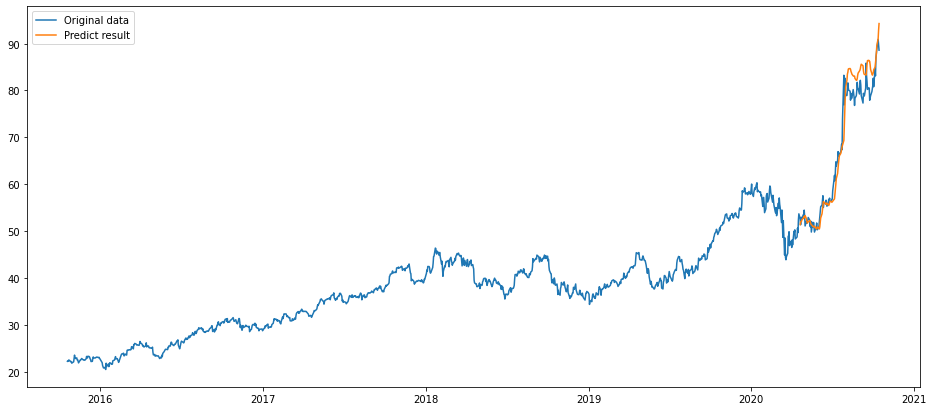

In [ ]:
# 預測結果圖示
plt.figure(figsize=(16, 7))
plt.plot(data.index, data, label='Original data')
plt.plot(data[sep_idx+window_size:].index, pred_test, label='Predict result')
plt.legend()
plt.show()